In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import maxentep
from maxentep import MetaModel, traj_quantile, patch_quantile, contact_infection_func, compartment_restrainer, weighted_quantile
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')
import time
import os
import seaborn as sns

# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
# reduce memory usage, in case you're
# on a machine with 1 GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
print (gpus)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        _tf_on_gpu = True
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)
Using TensorFlow backend.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [2]:
# Make up some populations (take as known)
M = 3
np.random.seed(0)
population = np.maximum(1000, np.round(np.random.normal(loc=100000, scale=25000, size=(M,)), 0))
area = np.maximum(250, np.round(np.random.normal(loc=2000, scale=1000, size=(M,)), 0))
print(area, population)
population_fraction = population/np.sum(population)
print (np.sum(population))

[4241. 3868. 1023.] [144101. 110004. 124468.]
378573.0


## Reference trajectory

In [3]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, [1,2])
tmat.add_transition('E', 'A', 7, 3)
tmat.add_transition('A', 'I', 5, 3)
tmat.add_transition('I', 'R', 14, 4)

In [4]:
infect_fxn = maxentep.contact_infection_func(infections_compartments)
timesteps = 250
model = maxentep.MetaModel(infect_fxn, timesteps, populations=population_fraction)

In [5]:
# starting fractions probabilities
start = np.zeros((M,C)) #anywhere
# start[0,0] = 0.1
# start[0,3] = 0.01
# start[0,1] = 0.2
start[0,2] = 0.02
start[0,1] = 0.05
np.random.seed(0)
# R = np.abs(np.random.normal(size=(M,M), loc=1.25))
R = np.array([[1000, 400, 10],
             [0, 300, 300],
             [300, 300, 1000]])
R_norm = R / np.sum(R, axis=1)
print (R_norm)
print(tmat.value)

[[0.70921986 0.66666667 0.00625   ]
 [0.         0.5        0.1875    ]
 [0.21276596 0.5        0.625     ]]
[[0.85714286 0.14285714 0.         0.        ]
 [0.         0.8        0.2        0.        ]
 [0.         0.         0.92857143 0.07142857]
 [0.         0.         0.         1.        ]]


In [6]:
ref_traj = model(R_norm, tmat.value, start, 0.025)[0]
print (ref_traj.shape)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(250, 3, 5)


In [7]:
# def f(beta, ntot, ninf):
#     p = 1 - tf.math.exp(tf.math.log(1 - tf.reshape(beta, (-1, 1)))
#                           * tf.reduce_sum((ninf) / ntot[:, :, tf.newaxis], axis=2))
#     return p
# p = []
# for i in np.linspace(0,1,10):
#     ninf = np.zeros((1,M), dtype = np.float32)
#     ninf[0,0] = i
#     print (f(0.01, np.ones((1,M), dtype = np.float32),ninf))
#     p.append(f(0.01, np.ones((1,M), dtype = np.float32),ninf))


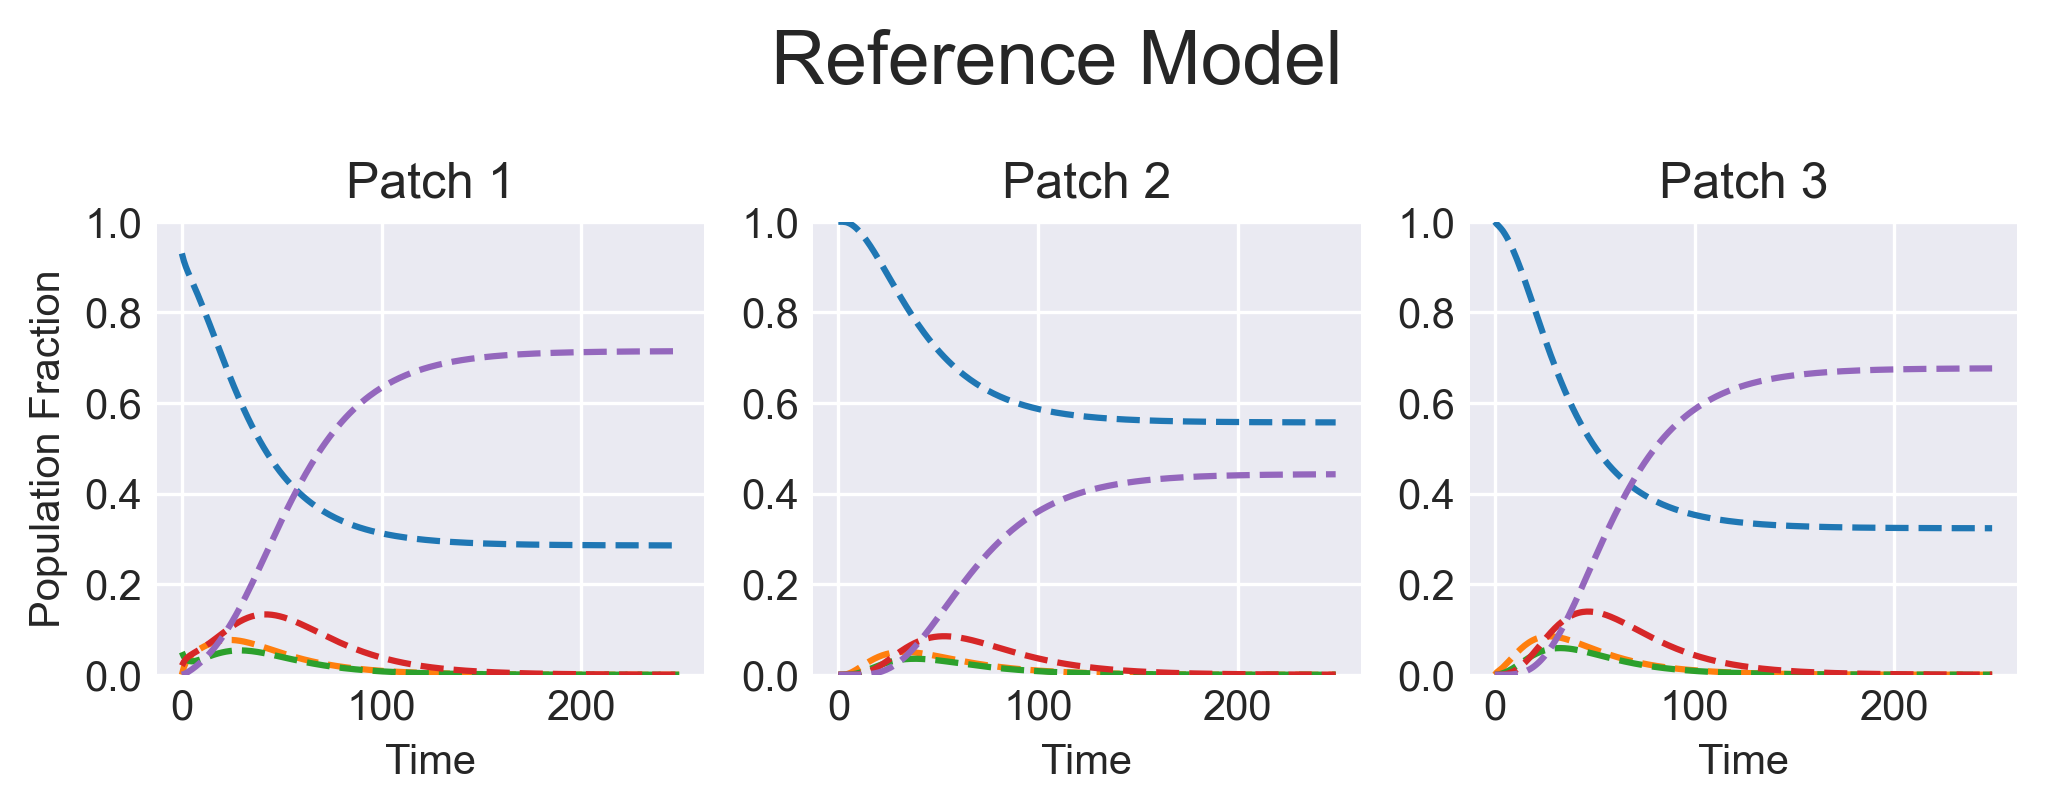

tf.Tensor(
[[9.3000001e-01 0.0000000e+00 5.0000001e-02 2.0000000e-02 0.0000000e+00]
 [9.1351068e-01 1.6489347e-02 4.0000003e-02 2.8571427e-02 1.4285714e-03]
 [9.0063554e-01 2.7008828e-02 3.4355622e-02 3.4530610e-02 3.4693875e-03]
 ...
 [2.8569031e-01 9.8567813e-05 8.5043037e-05 4.6003459e-04 7.1366608e-01]
 [2.8567964e-01 9.5171024e-05 8.2115548e-05 4.4418356e-04 7.1369892e-01]
 [2.8566933e-01 9.1897942e-05 7.9288300e-05 4.2887928e-04 7.1373063e-01]], shape=(230, 5), dtype=float32)
tf.Tensor(
[[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 ...
 [5.57283759e-01 1.12182679e-04 9.67724918e-05 5.21353155e-04
  4.41985935e-01]
 [5.57271600e-01 1.08315973e-04 9.34440905e-05 5.03468153e-04
  4.42023188e-01]
 [5.57259798e-01 1.04594495e-04 9.02289903e-05 4.86194942e-04
  4.42059159e-01]], shape=(230, 5),

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Reference Model', y = 1.2, fontsize = 18)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1])
    axs[i].plot(ref_traj[:,i],linestyle='--')
axs[0].set_ylabel('Population Fraction')
plt.show()
print (ref_traj[:-20:,0,:])
print (ref_traj[:-20:,1,:])
print (ref_traj[:-20:,1,:] == ref_traj[:-20:,0,:])
# print (tf.reduce_sum(ref_traj[:,0,:],axis=-1))

## Sample SEAIR Trajectories

Creating a set of trajectories.

In [9]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, infections_compartments)
tmat.add_transition('E', 'A', 8, 1)
tmat.add_transition('A', 'I', 2, 4)
tmat.add_transition('I', 'R', 15, 3)
full_compartments = ['S'] + compartments

In [10]:
# starting fractions probabilities
start_logits = np.zeros((M)) #anywhere
start_logits[0]=np.log(0.9)
hyper_pram = maxentep.ParameterHypers()
hyper_pram.beta_var = 0.9
hyper_pram.beta_start = 0.01
hyper_pram.beta_high = 0.15
hyper_pram.beta_low = 0.001
hyper_pram.start_mean = 0.001
hyper_pram.start_high = 0.4
hyper_pram.start_var = 0.5
# hyper_pram.R_var = 0.9
# hyper_pram.start_high = 0.01
# R_sample_norm = np.array([[0.1, 0.8, 0.1],
#              [0.05, 0.8, 0.15],
#              [0.01, 0.12, 0.87]])
# # R_sample_norm = R_sample / np.sum(R_sample, axis=1)

In [11]:
param_model = maxentep.MetaParameterJoint(start_logits, R_norm, tmat, name='unbiased model', hypers = hyper_pram)

In [12]:
import tqdm
#tf.debugging.enable_check_numerics()
N = 2048
batches = 4
batch_size = N*batches
outs = []
timesteps = 250
# infect_fxn = maxentep.contact_infection_func(infections_compartments, area=area)
model = maxentep.MetaModel(infect_fxn, timesteps, populations=population_fraction)
for b in tqdm.tqdm(range(batches)):
    psample = param_model.sample(N)
    outs.append(model(*psample))
trajs = np.concatenate(outs, axis=0)
print(trajs.shape)

100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.88s/it]

(8192, 250, 3, 5)


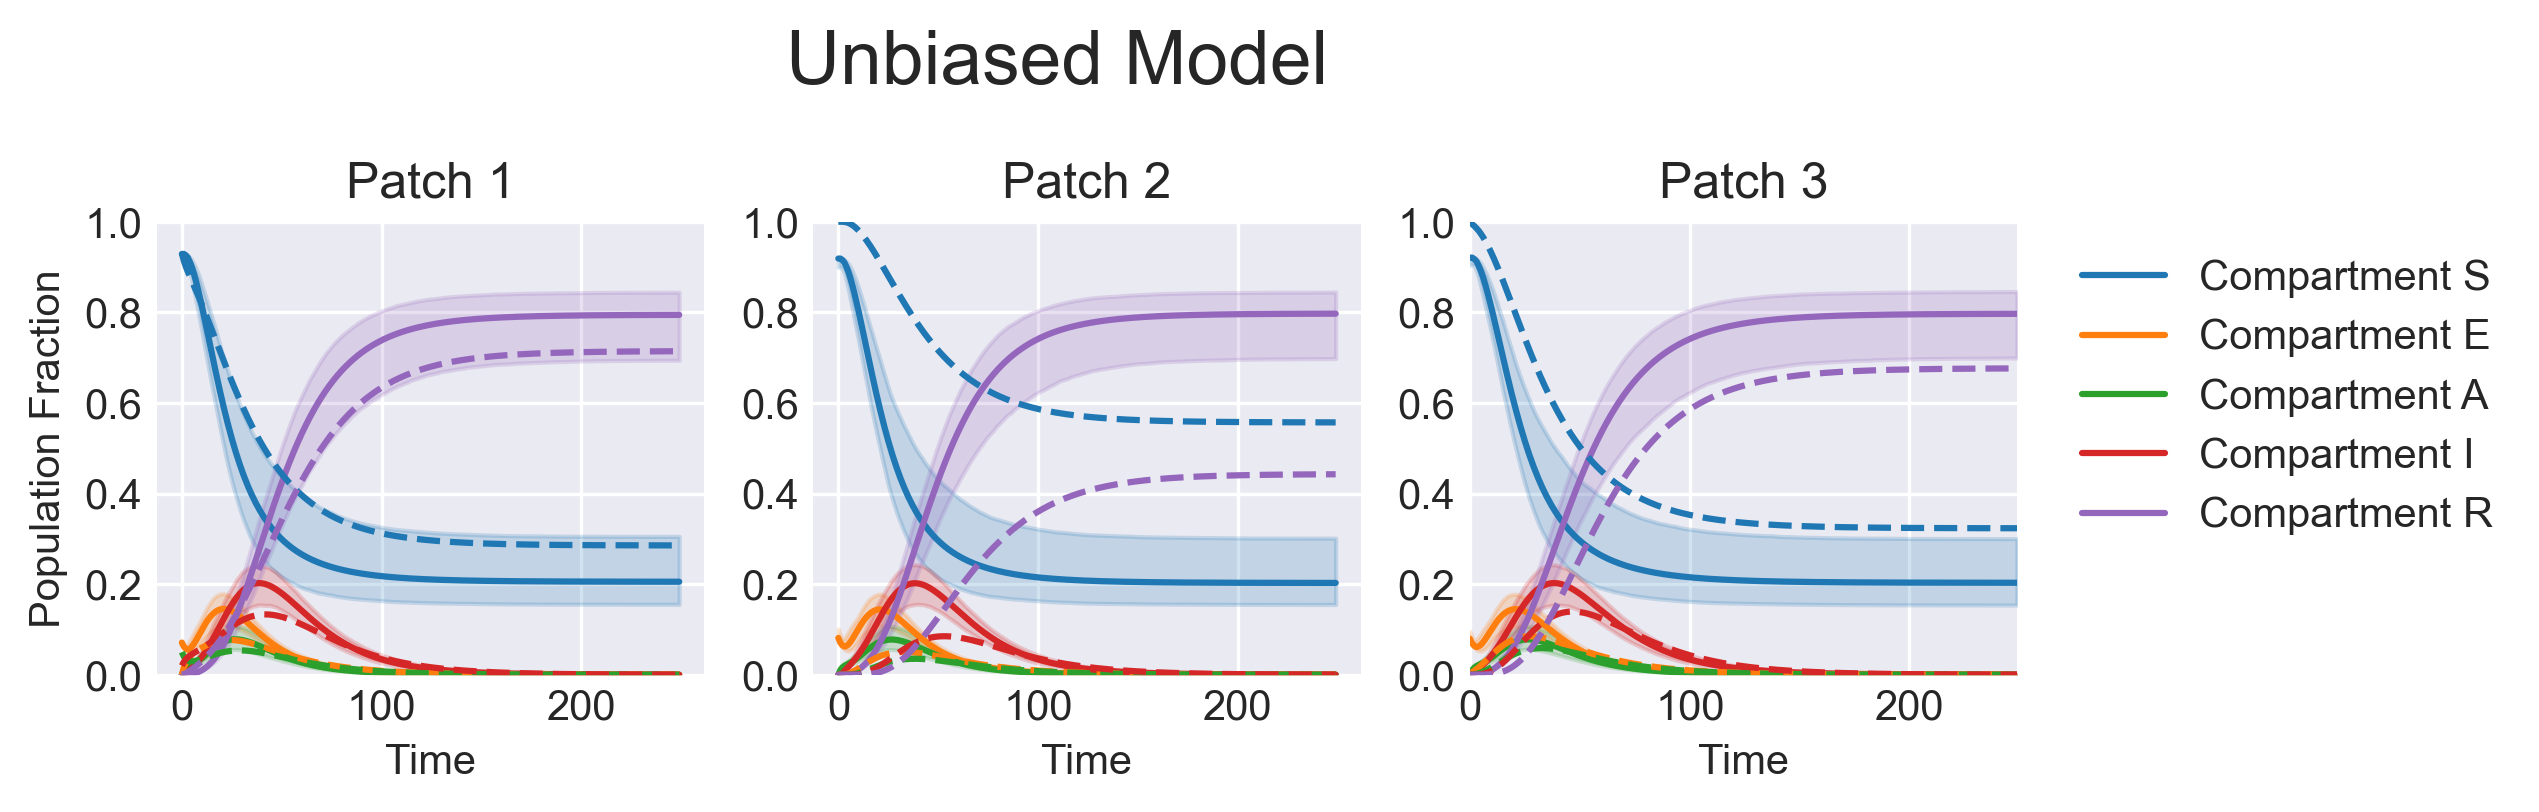

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Unbiased Model', y = 1.2, fontsize = 18)
maxentep.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
# maxentep.traj_quantile(revised_trajs_0, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(trajs[:,:,1,:], names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
# maxentep.traj_quantile(revised_trajs_1, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(trajs[:,:,2,:], names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
# maxentep.traj_quantile(revised_trajs_2, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
axs[0].set_ylabel('Population Fraction')
plt.show()

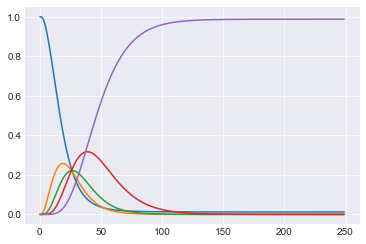

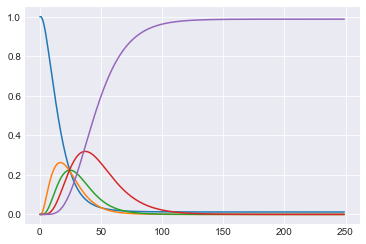

In [14]:
plt.plot(trajs[1234,:,1,:])
plt.show()
plt.plot(trajs[1234,:,2,:])
# print (trajs[:-20:,1,:] == trajs[:-20:,0,:])
# fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
# # fig.suptitle('Unbiased Model', y = 1.2, fontsize = 18)
# axs[0].plot(trajs[0,:,0,:])
# axs[1].plot(trajs[100,:,1,:])
# # maxentep.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
# # maxentep.traj_quantile(revised_trajs_0, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
# # maxentep.traj_quantile(trajs[:,:,1,:], names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
# # maxentep.traj_quantile(revised_trajs_1, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
# # maxentep.traj_quantile(trajs[:,:,2,:], names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
# # maxentep.traj_quantile(revised_trajs_2, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
# for i in range (M):
#     plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
#     axs[i].plot(ref_traj[:,i],linestyle='--')
# axs[0].set_ylabel('Population Fraction')
# plt.show()

## Make restraints from reference trajectory

In [15]:
npoints = 5
np.random.seed(0)
# prior = maxentep.EmptyPrior()
prior = maxentep.Laplace(0.01)
restrained_compartments = [3] #(infected patch)
restrained_compartments_names = [full_compartments[m] for m in restrained_compartments]
number_of_restrained_compartments = len(restrained_compartments) 
# restrained_patches = np.random.choice(M, number_of_restrained_patches, replace=False)
restrained_patches = np.array([0])
print ('Patches restrained:', restrained_patches)
print ('Total number of restraints: ', npoints*number_of_restrained_compartments*len(restrained_patches))
print ('Compartments restrained: ', restrained_compartments_names)
restraints, plot_fxns_list, restraints_dict = maxentep.compartment_restrainer(restrained_patches, restrained_compartments, npoints, ref_traj, prior, noise=0.05, start_time= 0, end_time = 100)

Patches restrained: [0]
Total number of restraints:  5
Compartments restrained:  ['I']
Restraints are set on this time range: [0, 100]
59 0.11300838 0.10784743734654037
45 0.13207568 0.15260560737936643
31 0.121692084 0.12889426233404105
80 0.06942841 0.1421420820039372
17 0.08018887 0.11824075668734235


In [16]:
print (restraints_dict)
print (ref_traj[59,0,3])
print (ref_traj[59,0,3] - restraints[0].target)

{'npoints': 5, 'restrained_patches': [0], 'restrained_compartments': [3]}
tf.Tensor(0.11310515, shape=(), dtype=float32)
tf.Tensor(0.005257711, shape=(), dtype=float32)


## Visualizing Restraints

Text(0, 0.5, 'Population Fraction')

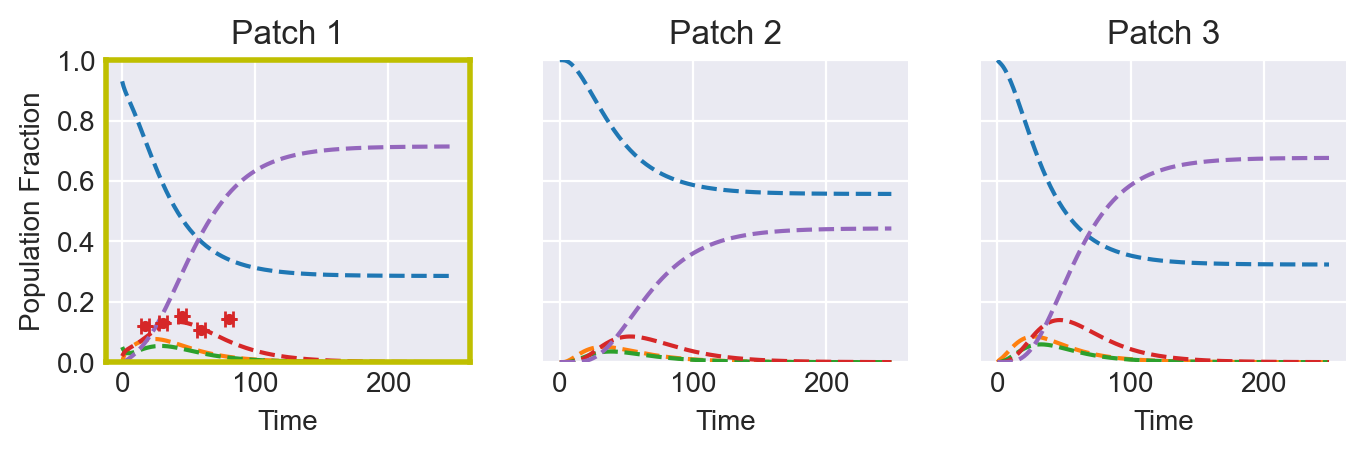

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=M, sharex=True,
                           sharey=True, figsize=(8,2), dpi =200)
for i in range(M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1),ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
    if i in restrained_patches:
        for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i)]):
                pf(axs[i],0, color='C3')
        axs[i].spines['bottom'].set_color('y')
        axs[i].spines['top'].set_color('y') 
        axs[i].spines['right'].set_color('y')
        axs[i].spines['left'].set_color('y')
        axs[i].spines['left'].set_linewidth(2)
        axs[i].spines['top'].set_linewidth(2)
        axs[i].spines['right'].set_linewidth(2)
        axs[i].spines['bottom'].set_linewidth(2)
axs[0].set_ylabel('Population Fraction')


In [18]:
me_model = maxentep.MaxentModel(restraints, ref_traj=ref_traj[np.newaxis,:,:,:], trajs=trajs, population_fraction=population_fraction)
me_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error')
print (ref_traj[np.newaxis,:,:,:].shape)
print (population_fraction.shape)
print (trajs.shape)

(1, 250, 3, 5)
(3,)
(8192, 250, 3, 5)


In [19]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self. i = 0
    def on_epoch_begin(self, epoch, logs=None):
        self.i += 1
        return self.i

In [20]:
me_history = me_model.fit(trajs, batch_size=batch_size,epochs=1000, callbacks=[CustomCallback()])

Epoch 1/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0022 - ref-error-metric: 1.5135 - ref-error: 1.5135 - weight-entropy: 9.0080
Epoch 2/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0022 - ref-error-metric: 1.5130 - ref-error: 1.5130 - weight-entropy: 9.0078
Epoch 3/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0022 - ref-error-metric: 1.5156 - ref-error: 1.5156 - weight-entropy: 9.0076
Epoch 4/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0022 - ref-error-metric: 1.5154 - ref-error: 1.5154 - weight-entropy: 9.0074
Epoch 5/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0022 - ref-error-metric: 1.5147 - ref-error: 1.5147 - weight-entropy: 9.0072
Epoch 6/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0022 - ref-error-metric: 1.5123 - ref-error: 1.5123 - weight-entropy: 9.0069
Epoch 7/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0022 - ref-err

1/1 [==============================] - 0s 1ms/step - loss: 0.0019 - ref-error-metric: 1.5185 - ref-error: 1.5185 - weight-entropy: 8.9882
Epoch 55/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0019 - ref-error-metric: 1.5207 - ref-error: 1.5207 - weight-entropy: 8.9876
Epoch 56/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0019 - ref-error-metric: 1.5118 - ref-error: 1.5118 - weight-entropy: 8.9871
Epoch 57/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0019 - ref-error-metric: 1.5177 - ref-error: 1.5177 - weight-entropy: 8.9866
Epoch 58/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0019 - ref-error-metric: 1.5147 - ref-error: 1.5147 - weight-entropy: 8.9861
Epoch 59/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0019 - ref-error-metric: 1.5121 - ref-error: 1.5121 - weight-entropy: 8.9856
Epoch 60/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0019 - ref-error-metric

1/1 [==============================] - 0s 1ms/step - loss: 0.0018 - ref-error-metric: 1.4993 - ref-error: 1.4993 - weight-entropy: 8.9607
Epoch 108/1000
1/1 [==============================] - 0s 994us/step - loss: 0.0018 - ref-error-metric: 1.5223 - ref-error: 1.5223 - weight-entropy: 8.9603
Epoch 109/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0018 - ref-error-metric: 1.5160 - ref-error: 1.5160 - weight-entropy: 8.9598
Epoch 110/1000
1/1 [==============================] - 0s 1000us/step - loss: 0.0018 - ref-error-metric: 1.5066 - ref-error: 1.5066 - weight-entropy: 8.9593
Epoch 111/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0018 - ref-error-metric: 1.5229 - ref-error: 1.5229 - weight-entropy: 8.9588
Epoch 112/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0018 - ref-error-metric: 1.5011 - ref-error: 1.5011 - weight-entropy: 8.9584
Epoch 113/1000
1/1 [==============================] - 0s 0s/step - loss: 0.0018 - ref-er

1/1 [==============================] - 0s 2ms/step - loss: 0.0017 - ref-error-metric: 1.5204 - ref-error: 1.5204 - weight-entropy: 8.9411
Epoch 161/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0017 - ref-error-metric: 1.5154 - ref-error: 1.5154 - weight-entropy: 8.9408
Epoch 162/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0017 - ref-error-metric: 1.5187 - ref-error: 1.5187 - weight-entropy: 8.9405
Epoch 163/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0017 - ref-error-metric: 1.5254 - ref-error: 1.5254 - weight-entropy: 8.9403
Epoch 164/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0017 - ref-error-metric: 1.5078 - ref-error: 1.5078 - weight-entropy: 8.9401
Epoch 165/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0017 - ref-error-metric: 1.5089 - ref-error: 1.5089 - weight-entropy: 8.9398
Epoch 166/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0017 - ref-error-metr

1/1 [==============================] - 0s 2ms/step - loss: 0.0017 - ref-error-metric: 1.4993 - ref-error: 1.4993 - weight-entropy: 8.9323
Epoch 214/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0017 - ref-error-metric: 1.5251 - ref-error: 1.5251 - weight-entropy: 8.9323
Epoch 215/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0017 - ref-error-metric: 1.5377 - ref-error: 1.5377 - weight-entropy: 8.9322
Epoch 216/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0017 - ref-error-metric: 1.5211 - ref-error: 1.5211 - weight-entropy: 8.9321
Epoch 217/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0017 - ref-error-metric: 1.5054 - ref-error: 1.5054 - weight-entropy: 8.9320
Epoch 218/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0017 - ref-error-metric: 1.5035 - ref-error: 1.5035 - weight-entropy: 8.9319
Epoch 219/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0017 - ref-error-

1/1 [==============================] - 0s 2ms/step - loss: 0.0017 - ref-error-metric: 1.5241 - ref-error: 1.5241 - weight-entropy: 8.9298
Epoch 267/1000
1/1 [==============================] - 0s 996us/step - loss: 0.0017 - ref-error-metric: 1.5144 - ref-error: 1.5144 - weight-entropy: 8.9298
Epoch 268/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0017 - ref-error-metric: 1.5371 - ref-error: 1.5371 - weight-entropy: 8.9297
Epoch 269/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0017 - ref-error-metric: 1.4816 - ref-error: 1.4816 - weight-entropy: 8.9297
Epoch 270/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0017 - ref-error-metric: 1.5288 - ref-error: 1.5288 - weight-entropy: 8.9297
Epoch 271/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0017 - ref-error-metric: 1.5233 - ref-error: 1.5233 - weight-entropy: 8.9297
Epoch 272/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0017 - ref-error-

1/1 [==============================] - 0s 997us/step - loss: 0.0017 - ref-error-metric: 1.5081 - ref-error: 1.5081 - weight-entropy: 8.9293
Epoch 320/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0017 - ref-error-metric: 1.5158 - ref-error: 1.5158 - weight-entropy: 8.9293
Epoch 321/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0017 - ref-error-metric: 1.5166 - ref-error: 1.5166 - weight-entropy: 8.9293
Epoch 322/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0017 - ref-error-metric: 1.5198 - ref-error: 1.5198 - weight-entropy: 8.9293
Epoch 323/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0017 - ref-error-metric: 1.5060 - ref-error: 1.5060 - weight-entropy: 8.9293
Epoch 324/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0017 - ref-error-metric: 1.5278 - ref-error: 1.5278 - weight-entropy: 8.9293
Epoch 325/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0017 - ref-erro

1/1 [==============================] - 0s 1ms/step - loss: 0.0017 - ref-error-metric: 1.5000 - ref-error: 1.5000 - weight-entropy: 8.9291
Epoch 373/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0017 - ref-error-metric: 1.5147 - ref-error: 1.5147 - weight-entropy: 8.9291
Epoch 374/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0017 - ref-error-metric: 1.5113 - ref-error: 1.5113 - weight-entropy: 8.9291
Epoch 375/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0017 - ref-error-metric: 1.5069 - ref-error: 1.5069 - weight-entropy: 8.9291
Epoch 376/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0017 - ref-error-metric: 1.5179 - ref-error: 1.5179 - weight-entropy: 8.9291
Epoch 377/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0017 - ref-error-metric: 1.5244 - ref-error: 1.5244 - weight-entropy: 8.9291
Epoch 378/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0017 - ref-error-me

1/1 [==============================] - 0s 1ms/step - loss: 0.0017 - ref-error-metric: 1.5031 - ref-error: 1.5031 - weight-entropy: 8.9288
Epoch 426/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0017 - ref-error-metric: 1.5197 - ref-error: 1.5197 - weight-entropy: 8.9288
Epoch 427/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0017 - ref-error-metric: 1.5088 - ref-error: 1.5088 - weight-entropy: 8.9288
Epoch 428/1000
1/1 [==============================] - 0s 999us/step - loss: 0.0017 - ref-error-metric: 1.5173 - ref-error: 1.5173 - weight-entropy: 8.9288
Epoch 429/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0017 - ref-error-metric: 1.4895 - ref-error: 1.4895 - weight-entropy: 8.9288
Epoch 430/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0017 - ref-error-metric: 1.5076 - ref-error: 1.5076 - weight-entropy: 8.9288
Epoch 431/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0017 - ref-erro

1/1 [==============================] - 0s 1ms/step - loss: 0.0017 - ref-error-metric: 1.5128 - ref-error: 1.5128 - weight-entropy: 8.9283
Epoch 479/1000
1/1 [==============================] - 0s 991us/step - loss: 0.0017 - ref-error-metric: 1.5255 - ref-error: 1.5255 - weight-entropy: 8.9283
Epoch 480/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0017 - ref-error-metric: 1.5261 - ref-error: 1.5261 - weight-entropy: 8.9282
Epoch 481/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0017 - ref-error-metric: 1.5119 - ref-error: 1.5119 - weight-entropy: 8.9282
Epoch 482/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0017 - ref-error-metric: 1.5046 - ref-error: 1.5046 - weight-entropy: 8.9282
Epoch 483/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0017 - ref-error-metric: 1.5082 - ref-error: 1.5082 - weight-entropy: 8.9282
Epoch 484/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0017 - ref-error-me

1/1 [==============================] - 0s 1ms/step - loss: 0.0016 - ref-error-metric: 1.5267 - ref-error: 1.5267 - weight-entropy: 8.9274
Epoch 532/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0016 - ref-error-metric: 1.5332 - ref-error: 1.5332 - weight-entropy: 8.9274
Epoch 533/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0016 - ref-error-metric: 1.5378 - ref-error: 1.5378 - weight-entropy: 8.9274
Epoch 534/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0016 - ref-error-metric: 1.5036 - ref-error: 1.5036 - weight-entropy: 8.9274
Epoch 535/1000
1/1 [==============================] - 0s 996us/step - loss: 0.0016 - ref-error-metric: 1.5245 - ref-error: 1.5245 - weight-entropy: 8.9273
Epoch 536/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0016 - ref-error-metric: 1.5268 - ref-error: 1.5268 - weight-entropy: 8.9273
Epoch 537/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0016 - ref-erro

1/1 [==============================] - 0s 1ms/step - loss: 0.0016 - ref-error-metric: 1.5147 - ref-error: 1.5147 - weight-entropy: 8.9262
Epoch 585/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0016 - ref-error-metric: 1.5160 - ref-error: 1.5160 - weight-entropy: 8.9262
Epoch 586/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0016 - ref-error-metric: 1.5139 - ref-error: 1.5139 - weight-entropy: 8.9262
Epoch 587/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0016 - ref-error-metric: 1.5102 - ref-error: 1.5102 - weight-entropy: 8.9262
Epoch 588/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0016 - ref-error-metric: 1.5170 - ref-error: 1.5170 - weight-entropy: 8.9261
Epoch 589/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0016 - ref-error-metric: 1.5190 - ref-error: 1.5190 - weight-entropy: 8.9261
Epoch 590/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0016 - ref-error-me

1/1 [==============================] - 0s 1ms/step - loss: 0.0016 - ref-error-metric: 1.5366 - ref-error: 1.5366 - weight-entropy: 8.9247
Epoch 638/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0016 - ref-error-metric: 1.5152 - ref-error: 1.5152 - weight-entropy: 8.9247
Epoch 639/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0016 - ref-error-metric: 1.5054 - ref-error: 1.5054 - weight-entropy: 8.9246
Epoch 640/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0016 - ref-error-metric: 1.5185 - ref-error: 1.5185 - weight-entropy: 8.9246
Epoch 641/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0016 - ref-error-metric: 1.5178 - ref-error: 1.5178 - weight-entropy: 8.9246
Epoch 642/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0016 - ref-error-metric: 1.5022 - ref-error: 1.5022 - weight-entropy: 8.9245
Epoch 643/1000
1/1 [==============================] - 0s 992us/step - loss: 0.0016 - ref-erro

1/1 [==============================] - 0s 2ms/step - loss: 0.0016 - ref-error-metric: 1.5128 - ref-error: 1.5128 - weight-entropy: 8.9228
Epoch 691/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0016 - ref-error-metric: 1.5026 - ref-error: 1.5026 - weight-entropy: 8.9228
Epoch 692/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0016 - ref-error-metric: 1.5064 - ref-error: 1.5064 - weight-entropy: 8.9227
Epoch 693/1000
1/1 [==============================] - 0s 999us/step - loss: 0.0016 - ref-error-metric: 1.5104 - ref-error: 1.5104 - weight-entropy: 8.9227
Epoch 694/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0016 - ref-error-metric: 1.5071 - ref-error: 1.5071 - weight-entropy: 8.9226
Epoch 695/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0016 - ref-error-metric: 1.5190 - ref-error: 1.5190 - weight-entropy: 8.9226
Epoch 696/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0016 - ref-error-me

1/1 [==============================] - 0s 2ms/step - loss: 0.0016 - ref-error-metric: 1.5097 - ref-error: 1.5097 - weight-entropy: 8.9205
Epoch 744/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0016 - ref-error-metric: 1.4981 - ref-error: 1.4981 - weight-entropy: 8.9205
Epoch 745/1000
1/1 [==============================] - 0s 1000us/step - loss: 0.0016 - ref-error-metric: 1.5136 - ref-error: 1.5136 - weight-entropy: 8.9204
Epoch 746/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0016 - ref-error-metric: 1.5236 - ref-error: 1.5236 - weight-entropy: 8.9204
Epoch 747/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0016 - ref-error-metric: 1.5109 - ref-error: 1.5109 - weight-entropy: 8.9203
Epoch 748/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0016 - ref-error-metric: 1.5240 - ref-error: 1.5240 - weight-entropy: 8.9203
Epoch 749/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0016 - ref-err

1/1 [==============================] - 0s 1ms/step - loss: 0.0016 - ref-error-metric: 1.5091 - ref-error: 1.5091 - weight-entropy: 8.9179
Epoch 797/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0016 - ref-error-metric: 1.5165 - ref-error: 1.5165 - weight-entropy: 8.9178
Epoch 798/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0016 - ref-error-metric: 1.5219 - ref-error: 1.5219 - weight-entropy: 8.9178
Epoch 799/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0016 - ref-error-metric: 1.4969 - ref-error: 1.4969 - weight-entropy: 8.9177
Epoch 800/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0016 - ref-error-metric: 1.5174 - ref-error: 1.5174 - weight-entropy: 8.9177
Epoch 801/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0016 - ref-error-metric: 1.5164 - ref-error: 1.5164 - weight-entropy: 8.9176
Epoch 802/1000
1/1 [==============================] - 0s 0s/step - loss: 0.0016 - ref-error

1/1 [==============================] - 0s 1ms/step - loss: 0.0015 - ref-error-metric: 1.5206 - ref-error: 1.5206 - weight-entropy: 8.9148
Epoch 850/1000
1/1 [==============================] - 0s 1000us/step - loss: 0.0015 - ref-error-metric: 1.5121 - ref-error: 1.5121 - weight-entropy: 8.9148
Epoch 851/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - ref-error-metric: 1.5155 - ref-error: 1.5155 - weight-entropy: 8.9147
Epoch 852/1000
1/1 [==============================] - 0s 999us/step - loss: 0.0015 - ref-error-metric: 1.5051 - ref-error: 1.5051 - weight-entropy: 8.9147
Epoch 853/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0015 - ref-error-metric: 1.4952 - ref-error: 1.4952 - weight-entropy: 8.9146
Epoch 854/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - ref-error-metric: 1.5206 - ref-error: 1.5206 - weight-entropy: 8.9145
Epoch 855/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0015 - ref-err

1/1 [==============================] - 0s 1ms/step - loss: 0.0015 - ref-error-metric: 1.5207 - ref-error: 1.5207 - weight-entropy: 8.9114
Epoch 903/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0015 - ref-error-metric: 1.5172 - ref-error: 1.5172 - weight-entropy: 8.9114
Epoch 904/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0015 - ref-error-metric: 1.5053 - ref-error: 1.5053 - weight-entropy: 8.9113
Epoch 905/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0015 - ref-error-metric: 1.5143 - ref-error: 1.5143 - weight-entropy: 8.9112
Epoch 906/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0015 - ref-error-metric: 1.5051 - ref-error: 1.5051 - weight-entropy: 8.9112
Epoch 907/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0015 - ref-error-metric: 1.5055 - ref-error: 1.5055 - weight-entropy: 8.9111
Epoch 908/1000
1/1 [==============================] - 0s 999us/step - loss: 0.0015 - ref-error-me

1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - ref-error-metric: 1.5256 - ref-error: 1.5256 - weight-entropy: 8.9076
Epoch 956/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0015 - ref-error-metric: 1.4998 - ref-error: 1.4998 - weight-entropy: 8.9076
Epoch 957/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - ref-error-metric: 1.5217 - ref-error: 1.5217 - weight-entropy: 8.9075
Epoch 958/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - ref-error-metric: 1.5120 - ref-error: 1.5120 - weight-entropy: 8.9074
Epoch 959/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - ref-error-metric: 1.5154 - ref-error: 1.5154 - weight-entropy: 8.9073
Epoch 960/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - ref-error-metric: 1.5272 - ref-error: 1.5272 - weight-entropy: 8.9073
Epoch 961/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - ref-error-metr

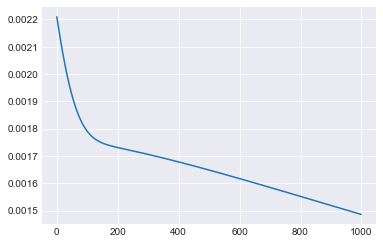

In [21]:
plt.plot(me_history.history['loss'])

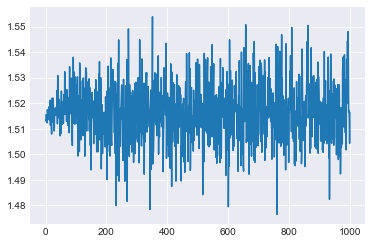

In [22]:
plt.plot(me_history.history['ref-error'])

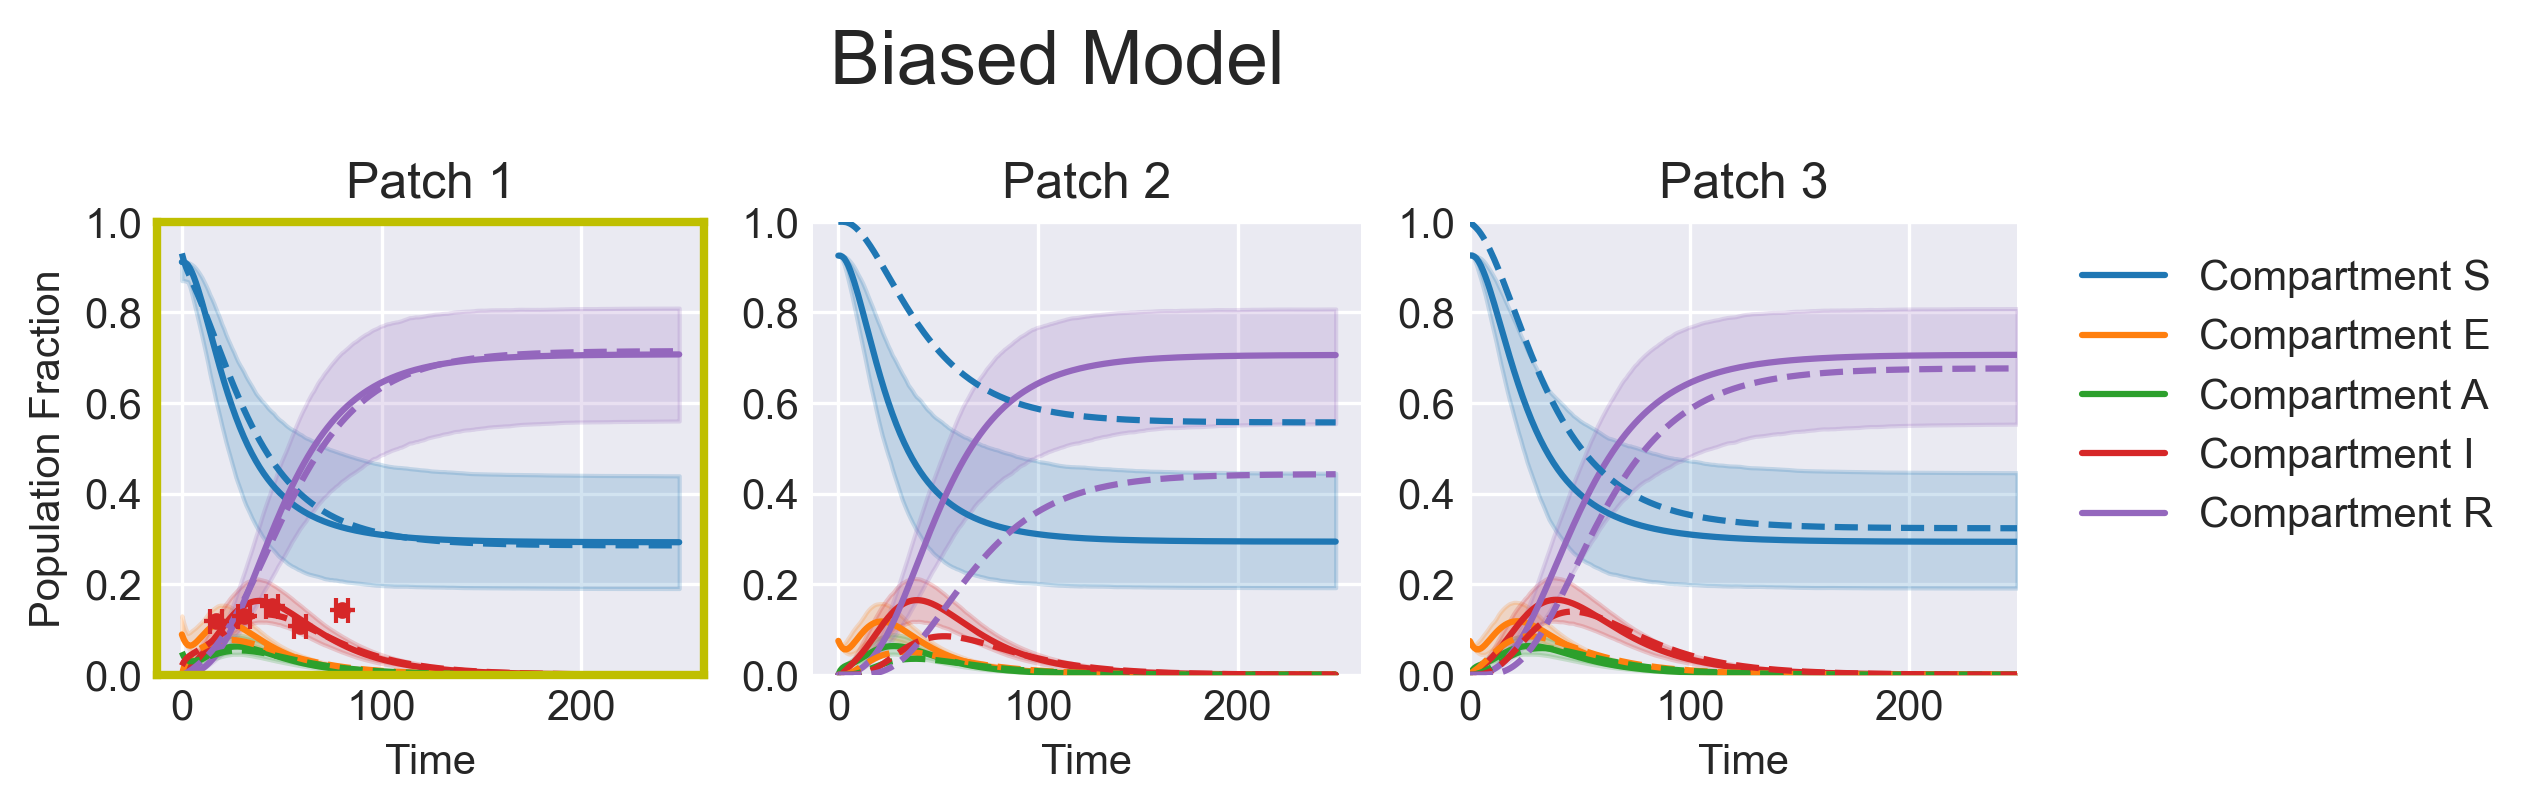

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Biased Model', y = 1.2, fontsize = 18)
maxentep.traj_quantile(me_model.trajs[:,:,0,:], weights=me_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(me_model.trajs[:,:,1,:], weights=me_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(me_model.trajs[:,:,2,:], weights=me_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
    if i in restrained_patches:
        for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i)]):
                pf(axs[i],0, color='C3')
        axs[i].spines['bottom'].set_color('y')
        axs[i].spines['top'].set_color('y') 
        axs[i].spines['right'].set_color('y')
        axs[i].spines['left'].set_color('y')
        axs[i].spines['left'].set_linewidth(2)
        axs[i].spines['top'].set_linewidth(2)
        axs[i].spines['right'].set_linewidth(2)
        axs[i].spines['bottom'].set_linewidth(2)
axs[0].set_ylabel('Population Fraction')
plt.show()

## Least squares regression

In [24]:
Tmtat = tmat.value
start = np.zeros((M, C))
start[0,0] = 0.05
# start[1,0] = 0.05
beta_start = 0.1
infect = maxentep.ContactInfectionLayer(beta_start, infections_compartments)
# make "agreement" function
def agreement(traj, rs=restraints):
    s = 0
    for r in rs:
        s += r(traj[0])**2
    return s
rmodel = maxentep.TrainableMetaModel(start, R_norm, Tmtat, infect, timesteps, agreement)

In [25]:
rmodel.compile(optimizer=tf.keras.optimizers.Nadam(0.01))
utraj = rmodel.get_traj()
rmodel.fit(timesteps)
regressed_traj = rmodel.get_traj()

250/250 [==============================] - 43s 174ms/step - loss: 0.0033 - output_2_loss: 0.0033


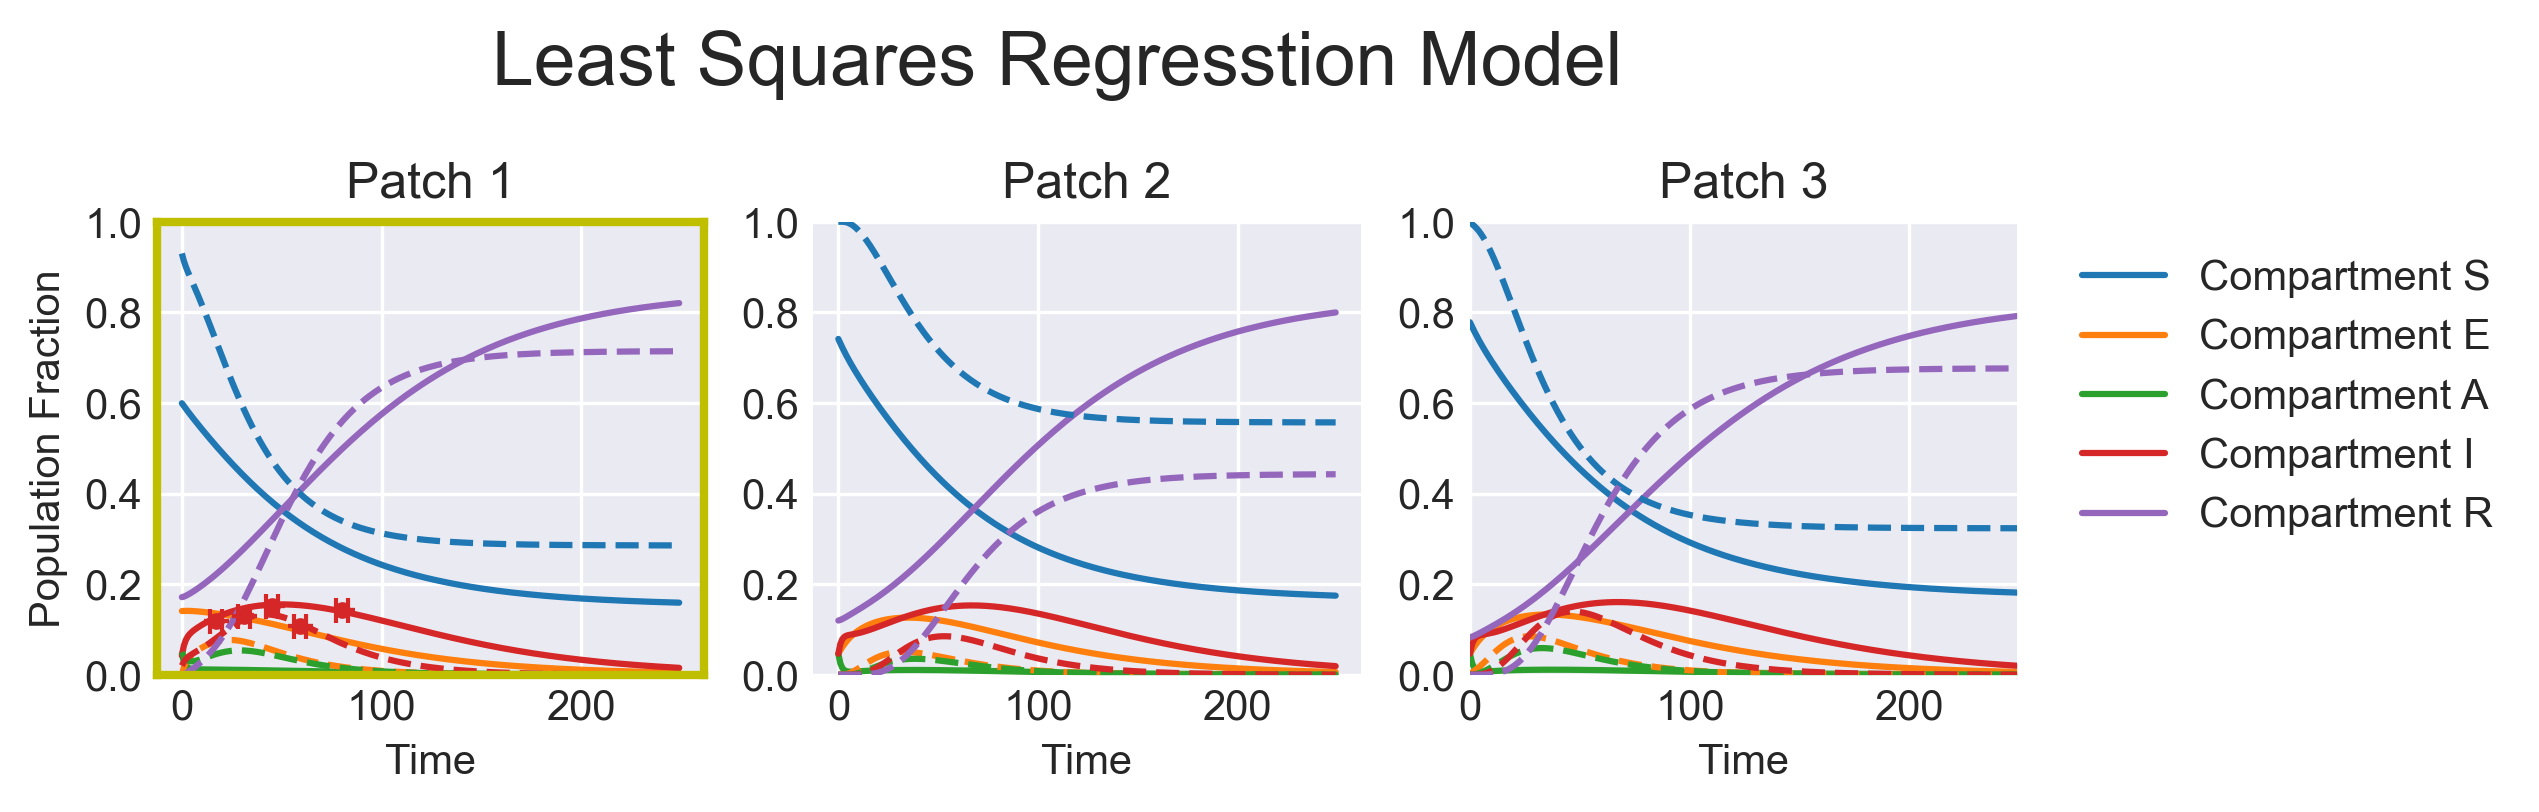

In [26]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Least Squares Regresstion Model', y = 1.2, fontsize = 18)
maxentep.traj_quantile(regressed_traj[:,:,0,:], names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(regressed_traj[:,:,1,:], names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(regressed_traj[:,:,2,:], names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
#     axs[i].plot(regressed_traj[0,:,i,:])
    if i in restrained_patches:
        for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i)]):
                pf(axs[i],0, color='C3')
        axs[i].spines['bottom'].set_color('y')
        axs[i].spines['top'].set_color('y') 
        axs[i].spines['right'].set_color('y')
        axs[i].spines['left'].set_color('y')
        axs[i].spines['left'].set_linewidth(2)
        axs[i].spines['top'].set_linewidth(2)
        axs[i].spines['right'].set_linewidth(2)
        axs[i].spines['bottom'].set_linewidth(2)
axs[0].set_ylabel('Population Fraction')
plt.show()

## Hyper-biasing

In [27]:
fit_param_model = maxentep.MetaParameterJoint(np.zeros((M,)), R_norm , tmat, name='unbiased_model', hypers = hyper_pram)
fit_param_model.compile(tf.optimizers.SGD(1))
# fit_param_model.compile(tf.optimizers.Adam(0.1))

hme_model = maxentep.HyperMaxentModel(restraints, fit_param_model, model, reweight=False)
hme_model.compile(tf.keras.optimizers.SGD(learning_rate=0.1), 'mean_squared_error')

In [28]:
hme_history = hme_model.fit(
    N, final_batch_multiplier=batches, 
    outter_epochs=1, param_epochs=16, batch_size=64, epochs=1000)

Epoch 1/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1589
Epoch 2/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1589
Epoch 3/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 4.1589
Epoch 4/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1589
Epoch 5/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1589
Epoch 6/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1589
Epoch 7/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1589
Epoch 8/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1589
Epoch 9/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 4.1589
Epoch 10/1000
128/128 [=====

128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1577
Epoch 70/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1577
Epoch 71/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1576
Epoch 72/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1576
Epoch 73/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1576
Epoch 74/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1575
Epoch 75/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1575
Epoch 76/1000
128/128 [==============================] - ETA: 0s - loss: 0.0023 - weight-entropy: 4.15 - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1575
Epoch 77/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-e

128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1543
Epoch 144/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1542
Epoch 145/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1542
Epoch 146/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1541
Epoch 147/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1541
Epoch 148/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1540
Epoch 149/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1539
Epoch 150/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1539: 0s - loss: 0.0021 - weight-entropy: 
Epoch 151/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-ent

128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1493
Epoch 218/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1493
Epoch 219/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1492
Epoch 220/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1491
Epoch 221/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1491
Epoch 222/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1490
Epoch 223/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1489
Epoch 224/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1488
Epoch 225/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1487
Epoch 226/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0020 - weight-entropy: 4.1434
Epoch 292/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0020 - weight-entropy: 4.1433
Epoch 293/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0020 - weight-entropy: 4.1432
Epoch 294/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0020 - weight-entropy: 4.1431
Epoch 295/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0020 - weight-entropy: 4.1431
Epoch 296/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1430
Epoch 297/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0020 - weight-entropy: 4.1429
Epoch 298/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0020 - weight-entropy: 4.1429
Epoch 299/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1427
Epoch 300/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0020 - weight-entropy: 4.1370
Epoch 366/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0020 - weight-entropy: 4.1369
Epoch 367/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0020 - weight-entropy: 4.1369
Epoch 368/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1368
Epoch 369/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0020 - weight-entropy: 4.1367
Epoch 370/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0020 - weight-entropy: 4.1366
Epoch 371/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0020 - weight-entropy: 4.1365
Epoch 372/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 4.1364
Epoch 373/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0020 - weight-entropy: 4.1363
Epoch 374/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 4.1306
Epoch 440/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 4.1304
Epoch 441/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 4.1304
Epoch 442/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 4.1303
Epoch 443/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 4.1302
Epoch 444/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 4.1301
Epoch 445/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 4.1300
Epoch 446/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 4.1299
Epoch 447/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 4.1298
Epoch 448/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 4.1241
Epoch 514/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 4.1240
Epoch 515/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 4.1240
Epoch 516/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 4.1240
Epoch 517/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 4.1238
Epoch 518/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 4.1238
Epoch 519/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 4.1237
Epoch 520/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 4.1235
Epoch 521/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 4.1234
Epoch 522/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.1180
Epoch 588/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 4.1179
Epoch 589/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 4.1180
Epoch 590/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 4.1180
Epoch 591/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.1177
Epoch 592/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.1176
Epoch 593/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 4.1176
Epoch 594/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.1174
Epoch 595/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.1173
Epoch 596/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.1123
Epoch 662/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.1121
Epoch 663/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.1121
Epoch 664/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.1120
Epoch 665/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.1119
Epoch 666/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.1120
Epoch 667/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.1118
Epoch 668/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.1118
Epoch 669/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.1116
Epoch 670/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.1072
Epoch 735/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.1070
Epoch 736/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.1067
Epoch 737/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.1071
Epoch 738/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.1070
Epoch 739/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.1072
Epoch 740/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.1067
Epoch 741/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.1066
Epoch 742/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.1063
Epoch 743/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.1021
Epoch 809/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.1022
Epoch 810/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.1020
Epoch 811/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.1021
Epoch 812/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.1020
Epoch 813/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.1019
Epoch 814/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.1019
Epoch 815/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.1018
Epoch 816/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.1018
Epoch 817/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.0976
Epoch 883/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.0980
Epoch 884/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.0975
Epoch 885/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.0977
Epoch 886/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.0977
Epoch 887/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0976
Epoch 888/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0976
Epoch 889/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.0975
Epoch 890/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.0974
Epoch 891/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.0940
Epoch 957/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.0938
Epoch 958/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0939
Epoch 959/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.0938
Epoch 960/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.0940
Epoch 961/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.0940
Epoch 962/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.0938
Epoch 963/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.0936
Epoch 964/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0939
Epoch 965/1000
128/128 [=

In [29]:
hme_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error') 
# hme_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), loss=ref_traj_loss)
hme_final_history = hme_model.fit(N, final_batch_multiplier=batches, outter_epochs=1, batch_size=64, epochs=200)

Epoch 1/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1446
Epoch 2/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.1016
Epoch 3/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 4.0813
Epoch 4/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.0790
Epoch 5/200
128/128 [==============================] - ETA: 0s - loss: 0.0017 - weight-entropy: 4.07 - 0s 1ms/step - loss: 0.0017 - weight-entropy: 4.0768
Epoch 6/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 4.0756
Epoch 7/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 4.0763
Epoch 8/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 4.0721
Epoch 9/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0016 - weight-entro

128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 3.6322
Epoch 71/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 3.6314
Epoch 72/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 3.6238
Epoch 73/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 3.6203
Epoch 74/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 3.6168
Epoch 75/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 3.6127
Epoch 76/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 3.6108
Epoch 77/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 3.6054
Epoch 78/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 3.6091
Epoch 79/200
128/128 [===================

128/128 [==============================] - 0s 1ms/step - loss: 0.0010 - weight-entropy: 3.4880
Epoch 146/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 3.4793
Epoch 147/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 3.4794
Epoch 148/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 3.4808
Epoch 149/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0010 - weight-entropy: 3.4821
Epoch 150/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 3.4737
Epoch 151/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 3.4787
Epoch 152/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 3.4776
Epoch 153/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 3.4798
Epoch 154/200
128/128 [==========

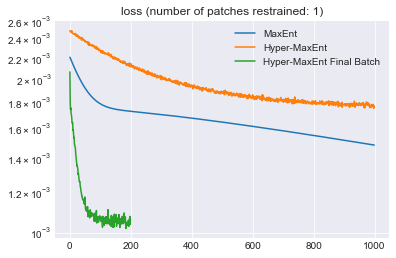

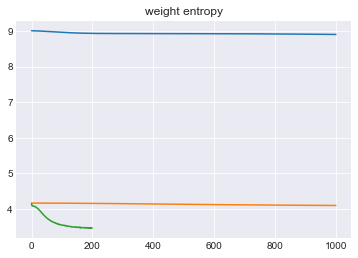

In [30]:
plt.plot(me_history.history['loss'],label='MaxEnt')
plt.plot(hme_history.history['loss'],label='Hyper-MaxEnt')
plt.plot(hme_final_history.history['loss'],label='Hyper-MaxEnt Final Batch')
plt.title('loss (number of patches restrained: {})'.format(len(restrained_patches)))
plt.yscale('log')
plt.legend()
# plt.savefig('loss_{}_restraints'.format(len(restrained_patches)),dpi= 300)
plt.show()

plt.plot(me_history.history['weight-entropy'])
plt.plot(hme_history.history['weight-entropy'])
plt.plot(hme_final_history.history['weight-entropy'])
plt.title('weight entropy')
plt.show()

# plt.plot(hme_history.history['prior-loss'])
# plt.title('neg log-likelihood')
# plt.show()

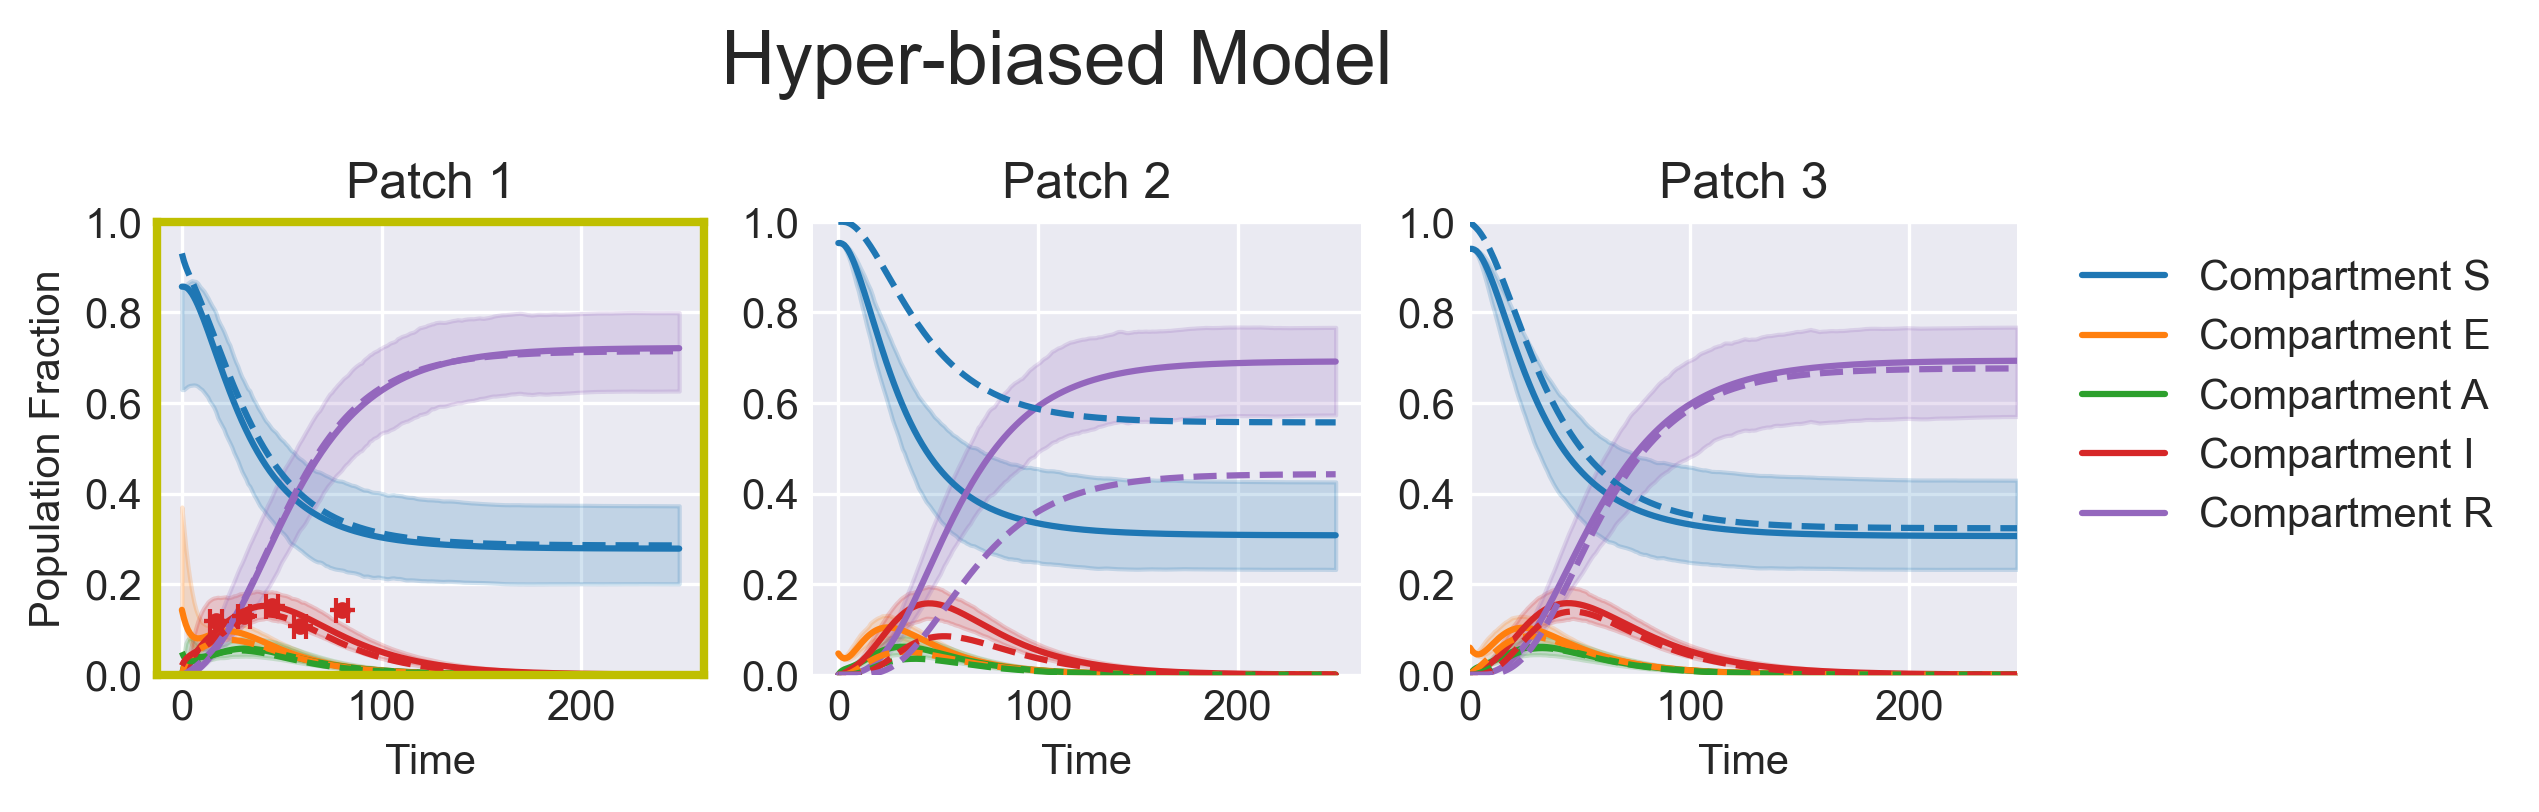

In [31]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Hyper-biased Model', y = 1.2, fontsize = 18)
maxentep.traj_quantile(hme_model.trajs[:,:,0,:], weights=hme_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(hme_model.trajs[:,:,1,:], weights=hme_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(hme_model.trajs[:,:,2,:], weights=hme_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
    if i in restrained_patches:
        for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i)]):
                pf(axs[i],0, color='C3')
        axs[i].spines['bottom'].set_color('y')
        axs[i].spines['top'].set_color('y') 
        axs[i].spines['right'].set_color('y')
        axs[i].spines['left'].set_color('y')
        axs[i].spines['left'].set_linewidth(2)
        axs[i].spines['top'].set_linewidth(2)
        axs[i].spines['right'].set_linewidth(2)
        axs[i].spines['bottom'].set_linewidth(2)
axs[0].set_ylabel('Population Fraction')
plt.show()

## ABC

In [34]:
# import pyabc
# import os
# beta = 0.025
# E_time = 7
# A_time = 5
# I_time = 14
# def sbi_model(parameters):
#     start, beta, E_time, A_time, I_time = parameters['start'], \
#                                                    + float(parameters['beta']), float(parameters['E_time']), \
#                                                    + float(parameters['A_time']), float(parameters['I_time'])
#     compartments = ['E', 'A', 'I', 'R']
#     infections_compartments = [1,2]
#     tmat = maxentep.TransitionMatrix(compartments, infections_compartments)
#     tmat.add_transition('E', 'A', E_time, 3)
#     tmat.add_transition('A', 'I', A_time, 3)
#     tmat.add_transition('I', 'R', I_time, 4)
#     infect_fxn_sbi = maxentep.contact_infection_func(infections_compartments)
#     timesteps = 250
#     meta_model = maxentep.MetaModel(infect_fxn_sbi, timesteps, populations=population_fraction)
#     trajectory = meta_model(R_norm, tmat.value, start, beta)[0]
#     restrainted_time_values = [59, 45, 31, 80, 17]
#     values = np.array([trajectory[m,0,3].numpy() for m in restrainted_time_values])
#     return {'data': values}
# sbi_param_keys = [ 'start', 'beta', 'E_time', 'A_time', 'I_time' ]
# sbi_param_values = [start, beta, E_time, A_time, I_time ] 
# sbi_parameters = dict(zip(sbi_param_keys, sbi_param_values))
# sbi_result = sbi_model(sbi_parameters)


# def distance(x, y):
#     print ('current calue', x['data'])
#     print ('goal', y['data'])
#     d = np.sum(np.abs(x['data'] - y['data']))
#     print (f'distance{d}')
#     return(d)

# # 59 0.11300838 0.10784743734654037
# # 45 0.13207568 0.15260560737936643
# # 31 0.121692084 0.12889426233404105
# # 80 0.06942841 0.1421420820039372
# # 17 0.08018887 0.11824075668734235
# print (sbi_result)

# # R_norm, start, beta, E_time, A_time, I_time 
# parameter_priors = pyabc.Distribution(# R_norm=pyabc.RV("norm", sbi_param_values[0], 1), 
#                                 start=pyabc.RV("norm", sbi_param_values[0], 0.01),
#                                 beta=pyabc.RV("norm", sbi_param_values[1], 0.1),
#                                 E_time=pyabc.RV("norm", sbi_param_values[2], 1),
#                                 A_time=pyabc.RV("norm", sbi_param_values[3], 1),
#                                 I_time=pyabc.RV("norm", sbi_param_values[4], 1))

# print(parameter_priors )



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



{'data': array([0.12532003, 0.14010824, 0.11538681, 0.07863417, 0.05513906],
      dtype=float32)}
<Distribution 'A_time', 'E_time', 'I_time', 'beta', 'start'>


In [38]:
# abc = pyabc.ABCSMC(sbi_model, parameter_priors, distance)
# db_path = 'sqlite:///' + os.path.join(os.getcwd(), 'abc_gravitation.db') 
# observation = np.array([r.target for r in restraints])
# abc.new(db_path, {'data': observation})
# # x_1 = np.array([0.009231301, 0.028030522, 0.08351496, 0.0017322148, 0.22831888])
# # x_2 = np.array([0.10784743734654037, 0.15260560737936643, 0.12889426233404105, 0.1421420820039372, 0.11824075668734235])
# # print(distance(x_1,x_2))
# print (observation)

KeyboardInterrupt: 

In [37]:
# import logging
# tf.get_logger().setLevel(logging.ERROR)
# history = abc.run(minimum_epsilon=0.1, max_nr_populations=5)

INFO:Epsilon:initial epsilon is 0.5832638263910389
INFO:ABC:t: 1, eps: 0.5832638263910389.


current calue [0.00052758 0.00133865 0.00338009 0.00013044 0.00810375]
goal [0.10784744 0.15260561 0.12889426 0.14214208 0.11824076]
distance0.6362496366874163
current calue [0.00050768 0.00146227 0.00403363 0.00010156 0.00952717]
goal [0.10784744 0.15260561 0.12889426 0.14214208 0.11824076]
distance0.6340978408571297
current calue [0.13757348 0.2084921  0.22690307 0.05655853 0.11624991]
goal [0.10784744 0.15260561 0.12889426 0.14214208 0.11824076]
distance0.2711957325252106
current calue [1.9362046e-04 5.8679900e-04 1.7710148e-03 3.6680474e-05 5.0493437e-03]
goal [0.10784744 0.15260561 0.12889426 0.14214208 0.11824076]
distance0.642092687363465
current calue [0.13032937 0.25416207 0.34148774 0.03641859 0.18586804]
goal [0.10784744 0.15260561 0.12889426 0.14214208 0.11824076]
distance0.509982650158388
current calue [0.09943781 0.22391567 0.40117368 0.02643587 0.3281317 ]
goal [0.10784744 0.15260561 0.12889426 0.14214208 0.11824076]
distance0.6775962646769559
current calue [0.000715   0

IndexError: index 0 is out of bounds for axis 0 with size 0

(3, 250, 3, 5)


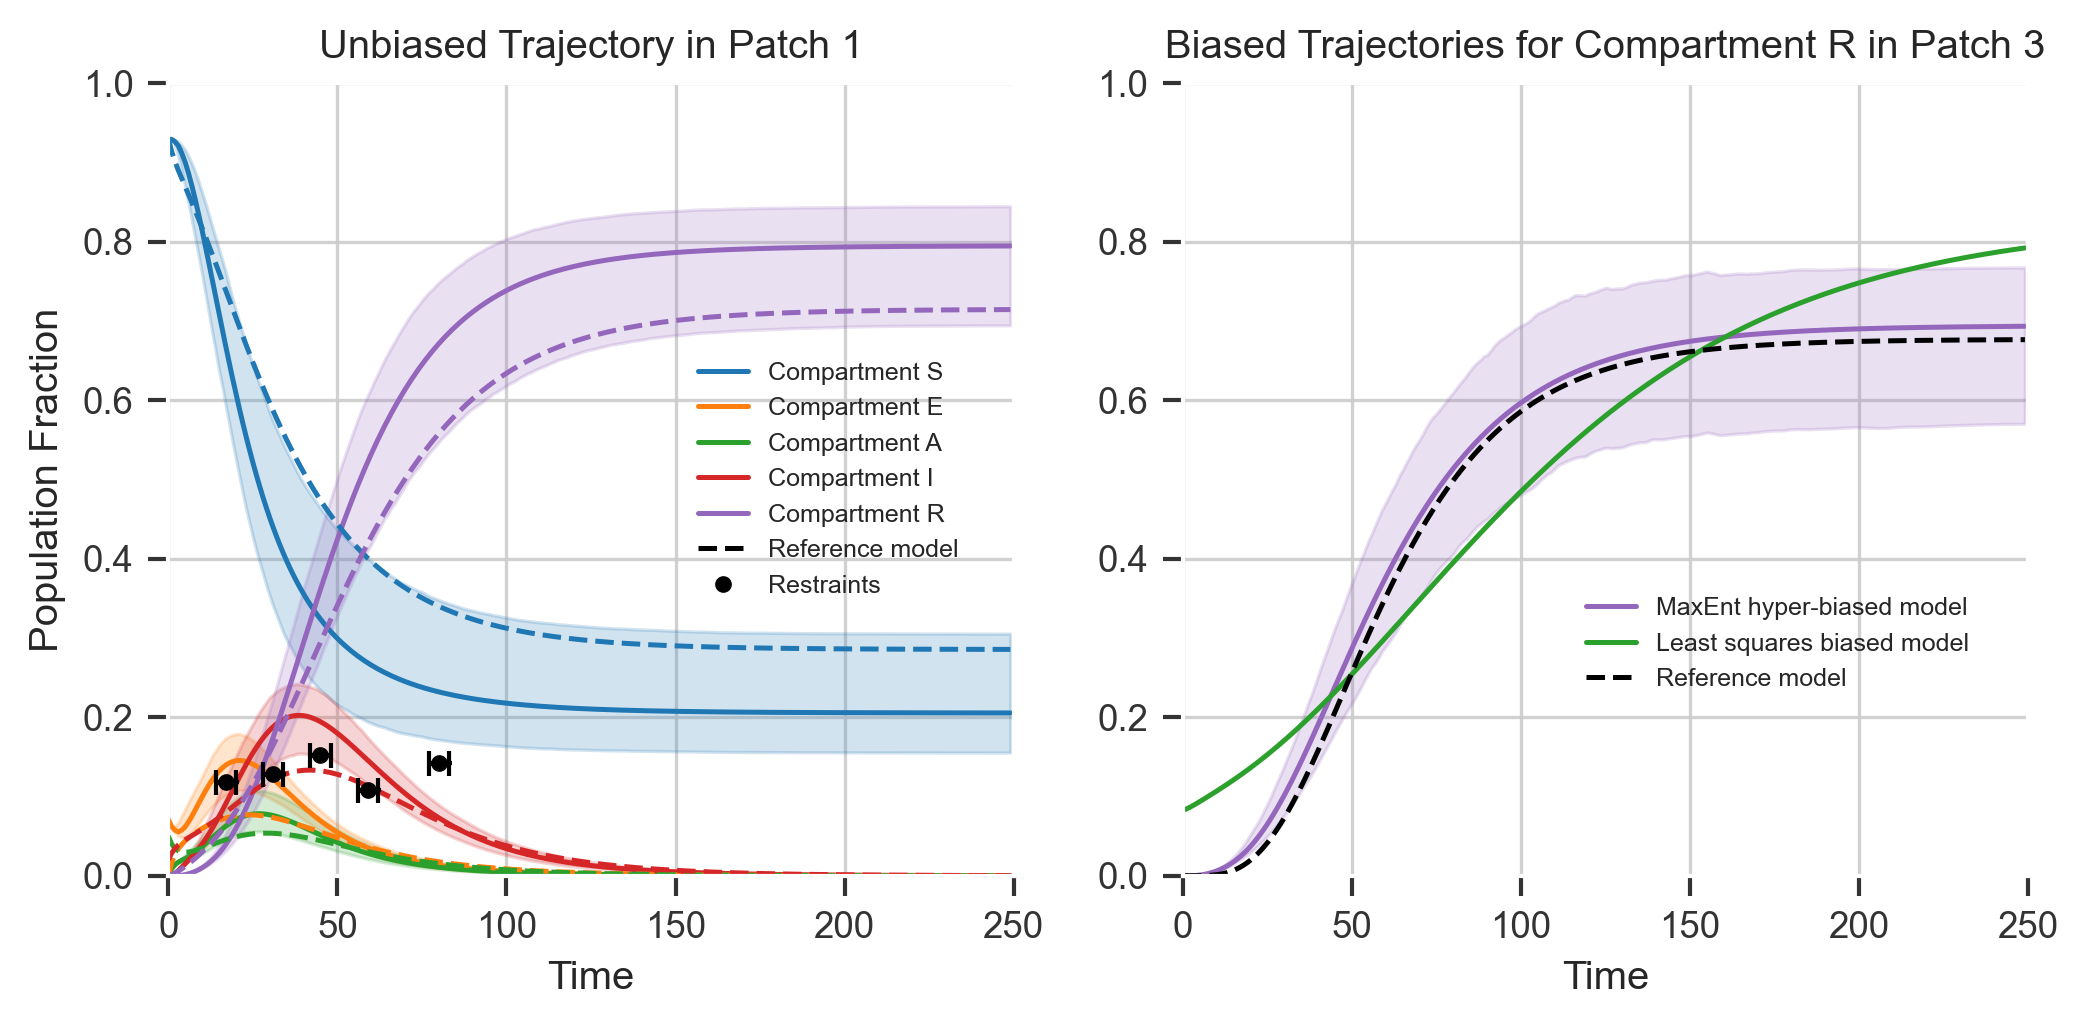

In [32]:
plt.rc('axes', titlesize=8)

import seaborn as sns
sns.set_context('paper')
sns.set_style('darkgrid',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#333333', 'ytick.color': '#333333'})
plt.rcParams["mathtext.fontset"] = "dejavuserif"
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e']


import matplotlib.markers as mmark
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.9
plt.rcParams['grid.color'] = "#cccccc"
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,3.5), dpi =300)

# fig.suptitle('Comparing Methods Performance', y = 1.0, fontsize = 18)
maxentep.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True, ax =axs[0], add_legend= True, alpha = 0.2)
axs[0].plot(ref_traj[:,0],linestyle='--')
axs[0].set_ylabel('Population Fraction')
plt.setp(axs[0], xlabel='Time', title = 'Unbiased Trajectory in Patch 1', xlim =[0, 250], ylim =[0, 1.0], facecolor ='white' )
for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(0)]):
                pf(axs[0],0, color='black')
Reference_line = plt.Line2D((0,1),(0,0), color='k', linestyle='--')
rs_marker = plt.Line2D((0,1),(0,0), color='k', marker='o',linestyle='', ms=3)
hand, labl = axs[0].get_legend_handles_labels()
Reference_label = 'Reference model'
Restraints_label = 'Restraints'
axs[0].legend([handle for i,handle in enumerate(hand)]+[Reference_line,rs_marker],
              [label for i,label in enumerate(labl)]+[Reference_label,Restraints_label]
                , bbox_to_anchor=(0.6,0.5), fontsize=6)


plt.setp(axs[1], xlabel='Time', title = 'Biased Trajectories for Compartment R in Patch 3', xlim =[0, 250], ylim =[0, 1.0], facecolor ='white' )
mtrajs_biased = np.sum(me_model.trajs * me_model.traj_weights[:, np.newaxis, np.newaxis, np.newaxis], axis=0)
mtrajs_hyperbiased = np.sum(hme_model.trajs * hme_model.traj_weights[:, np.newaxis, np.newaxis, np.newaxis], axis=0)
mtrajs_regressedbiased = np.sum(regressed_traj, axis=0)
x = range(trajs.shape[1])
# axs[1].plot(x, mtrajs_biased[:,2,4], color= 'C0', label='MaxEnt biased model')
qtrajs_hyperbiased = np.apply_along_axis(lambda x: maxentep.weighted_quantile(
    x, [1/3, 1/2, 2/3], sample_weight=hme_model.traj_weights), 0, hme_model.trajs)
qtrajs_hyperbiased[0, :, :] = np.clip(
            qtrajs_hyperbiased[0, :, :] - qtrajs_hyperbiased[1, :, :] + mtrajs_hyperbiased, 0, 1)
qtrajs_hyperbiased[2, :, :] = np.clip(
            qtrajs_hyperbiased[2, :, :] - qtrajs_hyperbiased[1, :, :] + mtrajs_hyperbiased, 0, 1)
qtrajs_hyperbiased[1, :, :] = mtrajs_hyperbiased
print(qtrajs_hyperbiased.shape)
axs[1].plot(x, mtrajs_hyperbiased[:,2,4], color= 'C4',  label='MaxEnt hyper-biased model')
axs[1].fill_between(x, qtrajs_hyperbiased[0, :, 2, 4],qtrajs_hyperbiased[-1, :, 2, 4],
                        color='C4', alpha=0.2)
axs[1].plot(x, mtrajs_regressedbiased[:,2,4], color= 'C2',  label='Least squares biased model')
axs[1].plot(ref_traj[:,2,4],linestyle='--', color= 'k', label='Reference model')
axs[1].legend(bbox_to_anchor=(0.45,0.38), fontsize=6)
plt.savefig('neurips.png', transparent=False, dpi = 300)


In [33]:
print (restraints)
print(hme_model.trajs.shape)

[<maxentep.maxent.Restraint object at 0x0000025B0BB4ECC8>, <maxentep.maxent.Restraint object at 0x0000025B0BB4EDC8>, <maxentep.maxent.Restraint object at 0x0000025B0BB4EE88>, <maxentep.maxent.Restraint object at 0x0000025B0BB4EF88>, <maxentep.maxent.Restraint object at 0x0000025B0BB56048>]
(8192, 250, 3, 5)


In [34]:
LS_sample_trajs = np.empty((npoints,trajs.shape[1],trajs.shape[2],trajs.shape[-1]))
HyperMaxEnt_sample_trajs = np.empty_like(LS_sample_trajs)
for i in range(npoints):
    sampled_restraints = [n for n in restraints if n != restraints[i]]
    def new_agreement(traj, rs=sampled_restraints):
        s = 0
        for r in rs:
            s += r(traj[0])**2
        return s
    rmodel_sampled = maxentep.TrainableMetaModel(start, R_norm, Tmtat, infect, timesteps, new_agreement)
    rmodel_sampled.compile(optimizer=tf.keras.optimizers.Nadam(0.01))
    utraj_sampled = rmodel_sampled.get_traj()
    rmodel_sampled.fit(timesteps)
    regressed_traj_sampled = rmodel_sampled.get_traj()
    LS_sample_trajs[i,:,:,:] = regressed_traj_sampled
    
    hme_model_sample = maxentep.HyperMaxentModel(sampled_restraints, fit_param_model, model, reweight=False)
    hme_model_sample.compile(tf.keras.optimizers.SGD(learning_rate=0.1), 'mean_squared_error')
    hme_history_sample = hme_model_sample.fit(
    N, final_batch_multiplier=batches, 
    outter_epochs=1, param_epochs=16, batch_size=64, epochs=1000)
    hme_model_sample.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error') 
    # hme_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), loss=ref_traj_loss)
    hme_final_history_sample = hme_model_sample.fit(N, final_batch_multiplier=batches, outter_epochs=1, batch_size=64, epochs=200)
    HyperMaxEnt_sample_trajs[i,:,:,:] = np.sum(hme_model_sample.trajs * hme_model_sample.traj_weights[:, np.newaxis, np.newaxis, np.newaxis], axis=0)

250/250 [==============================] - 38s 151ms/step - loss: 0.0013 - output_2_loss: 0.0013
Epoch 1/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 4.1589
Epoch 2/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1589
Epoch 3/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1589
Epoch 4/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1589
Epoch 5/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1589
Epoch 6/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1589
Epoch 7/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 4.1589
Epoch 8/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 4.1589
Epoch 9/1000
128/128 [=================

128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1581
Epoch 70/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 4.1581
Epoch 71/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1581
Epoch 72/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1581
Epoch 73/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 4.1580
Epoch 74/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1580
Epoch 75/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1580
Epoch 76/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1580
Epoch 77/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0026 - weight-entropy: 4.1579
Epoch 78/1000
128/128 [==========

128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1559
Epoch 144/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1558
Epoch 145/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1558
Epoch 146/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1558
Epoch 147/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1557
Epoch 148/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 4.1557
Epoch 149/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1557
Epoch 150/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 4.1556
Epoch 151/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 4.1556
Epoch 152/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1526
Epoch 218/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 4.1526
Epoch 219/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1525
Epoch 220/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1525
Epoch 221/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1524
Epoch 222/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1524
Epoch 223/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1523
Epoch 224/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1523
Epoch 225/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1522
Epoch 226/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1487
Epoch 292/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1486
Epoch 293/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1485
Epoch 294/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1485
Epoch 295/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1485
Epoch 296/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1484
Epoch 297/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1483
Epoch 298/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1483
Epoch 299/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1482
Epoch 300/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1443
Epoch 366/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1443
Epoch 367/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1442
Epoch 368/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1441
Epoch 369/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1441
Epoch 370/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1440
Epoch 371/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1440
Epoch 372/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1439
Epoch 373/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1438
Epoch 374/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1398
Epoch 440/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1398
Epoch 441/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1396
Epoch 442/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1397
Epoch 443/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1395
Epoch 444/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1395
Epoch 445/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1395
Epoch 446/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1393
Epoch 447/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1393
Epoch 448/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1354
Epoch 514/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1353
Epoch 515/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1352
Epoch 516/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1353
Epoch 517/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1351
Epoch 518/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1351
Epoch 519/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1351
Epoch 520/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1349
Epoch 521/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1349
Epoch 522/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1309
Epoch 588/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1309
Epoch 589/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1309
Epoch 590/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1308
Epoch 591/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1307
Epoch 592/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1306
Epoch 593/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1306
Epoch 594/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1307
Epoch 595/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1306
Epoch 596/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1267
Epoch 662/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1268
Epoch 663/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1268
Epoch 664/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1268
Epoch 665/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1266
Epoch 666/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1266
Epoch 667/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1264
Epoch 668/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1265
Epoch 669/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1263
Epoch 670/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1228
Epoch 736/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1228
Epoch 737/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1228
Epoch 738/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1227
Epoch 739/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1228
Epoch 740/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1226
Epoch 741/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1225
Epoch 742/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1226
Epoch 743/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1225
Epoch 744/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1194
Epoch 810/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1192
Epoch 811/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1192
Epoch 812/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1189
Epoch 813/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1190
Epoch 814/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1189
Epoch 815/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1190
Epoch 816/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1189
Epoch 817/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1187
Epoch 818/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1160
Epoch 884/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1158
Epoch 885/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1160
Epoch 886/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1156
Epoch 887/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1159
Epoch 888/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0021 - weight-entropy: 4.1157
Epoch 889/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1156
Epoch 890/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1154
Epoch 891/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1154
Epoch 892/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1129
Epoch 957/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1130
Epoch 958/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1128
Epoch 959/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1125
Epoch 960/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1127
Epoch 961/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1128
Epoch 962/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1126
Epoch 963/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1128
Epoch 964/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1126
Epoch 965/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 3.9243
Epoch 25/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0014 - weight-entropy: 3.9107
Epoch 26/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0014 - weight-entropy: 3.8932
Epoch 27/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 3.8817
Epoch 28/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 3.8651
Epoch 29/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 3.8517
Epoch 30/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.8364
Epoch 31/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 3.8207
Epoch 32/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 3.8061
Epoch 33/200
128/128 [===================

128/128 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 3.3720
Epoch 100/200
128/128 [==============================] - 0s 1ms/step - loss: 9.7224e-04 - weight-entropy: 3.3631
Epoch 101/200
128/128 [==============================] - 0s 1ms/step - loss: 9.9263e-04 - weight-entropy: 3.3577
Epoch 102/200
128/128 [==============================] - 0s 1ms/step - loss: 9.8884e-04 - weight-entropy: 3.3597
Epoch 103/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0010 - weight-entropy: 3.3560
Epoch 104/200
128/128 [==============================] - 0s 1ms/step - loss: 9.9147e-04 - weight-entropy: 3.3517
Epoch 105/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 3.3374
Epoch 106/200
128/128 [==============================] - 0s 1ms/step - loss: 9.9674e-04 - weight-entropy: 3.3478
Epoch 107/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0010 - weight-entropy: 3.3424
Epoch 108/200

128/128 [==============================] - 0s 1ms/step - loss: 0.0010 - weight-entropy: 3.2665
Epoch 173/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 3.2705
Epoch 174/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 3.2576
Epoch 175/200
128/128 [==============================] - 0s 2ms/step - loss: 9.7348e-04 - weight-entropy: 3.2596
Epoch 176/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0010 - weight-entropy: 3.2674
Epoch 177/200
128/128 [==============================] - 0s 2ms/step - loss: 9.9398e-04 - weight-entropy: 3.2523
Epoch 178/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0010 - weight-entropy: 3.2515
Epoch 179/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 3.2604
Epoch 180/200
128/128 [==============================] - 0s 1ms/step - loss: 9.7303e-04 - weight-entropy: 3.2645
Epoch 181/200
128/128

128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1588
Epoch 40/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1588
Epoch 41/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1588
Epoch 42/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 4.1588
Epoch 43/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1588
Epoch 44/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1588
Epoch 45/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1588
Epoch 46/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1588
Epoch 47/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1588
Epoch 48/1000
128/128 [==========

128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1582
Epoch 114/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1582
Epoch 115/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 4.1582
Epoch 116/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1582
Epoch 117/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1581
Epoch 118/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1581
Epoch 119/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1581
Epoch 120/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1581
Epoch 121/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 4.1581
Epoch 122/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 4.1571
Epoch 188/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1571
Epoch 189/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 4.1571
Epoch 190/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1570
Epoch 191/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1570
Epoch 192/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 4.1570
Epoch 193/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1570
Epoch 194/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1570
Epoch 195/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1570
Epoch 196/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1556
Epoch 262/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 4.1556
Epoch 263/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1556
Epoch 264/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1555
Epoch 265/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1555
Epoch 266/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1555
Epoch 267/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1555
Epoch 268/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 4.1554
Epoch 269/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 4.1554
Epoch 270/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 4.1538
Epoch 336/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1538
Epoch 337/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 4.1537
Epoch 338/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 4.1537
Epoch 339/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 4.1537
Epoch 340/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 4.1536
Epoch 341/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0024 - weight-entropy: 4.1536
Epoch 342/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 4.1536
Epoch 343/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 4.1535
Epoch 344/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1517
Epoch 409/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 4.1517: 0s - loss: 0.0024 - weight-entropy: 
Epoch 410/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1516
Epoch 411/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1516
Epoch 412/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1516
Epoch 413/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1516
Epoch 414/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1516
Epoch 415/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 4.1515
Epoch 416/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-ent

128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1494
Epoch 483/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1494
Epoch 484/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 4.1494
Epoch 485/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1494
Epoch 486/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1493
Epoch 487/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1493
Epoch 488/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1493
Epoch 489/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1492
Epoch 490/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 4.1492
Epoch 491/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1471
Epoch 557/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1470
Epoch 558/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1470
Epoch 559/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1469
Epoch 560/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1469
Epoch 561/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1469
Epoch 562/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1469
Epoch 563/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1468
Epoch 564/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1468
Epoch 565/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1446
Epoch 631/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1445
Epoch 632/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1445
Epoch 633/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1445
Epoch 634/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1444
Epoch 635/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1444
Epoch 636/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1444
Epoch 637/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1443
Epoch 638/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1443
Epoch 639/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1420
Epoch 705/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1420
Epoch 706/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1420
Epoch 707/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1419
Epoch 708/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1420
Epoch 709/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1418
Epoch 710/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1418
Epoch 711/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0023 - weight-entropy: 4.1418
Epoch 712/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1417
Epoch 713/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1395
Epoch 779/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1394
Epoch 780/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1394
Epoch 781/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1394
Epoch 782/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1394
Epoch 783/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1392
Epoch 784/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1392
Epoch 785/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1393
Epoch 786/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1392
Epoch 787/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1369
Epoch 853/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1369
Epoch 854/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1368
Epoch 855/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1368
Epoch 856/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1368
Epoch 857/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1368
Epoch 858/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1368
Epoch 859/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1366
Epoch 860/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1367
Epoch 861/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1344
Epoch 926/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1343
Epoch 927/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1345
Epoch 928/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1344
Epoch 929/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1344
Epoch 930/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1343
Epoch 931/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1342
Epoch 932/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1342
Epoch 933/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1341
Epoch 934/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1320
Epoch 1000/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1319
Epoch 1/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 4.1521
Epoch 2/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1253
Epoch 3/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1075
Epoch 4/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1011
Epoch 5/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.0942
Epoch 6/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.0936
Epoch 7/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.0942
Epoch 8/200
128/128 [========================

128/128 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.6254
Epoch 69/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.6261
Epoch 70/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.6203
Epoch 71/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.6157
Epoch 72/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.6113
Epoch 73/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.6047
Epoch 74/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.6055
Epoch 75/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.5986
Epoch 76/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.5956
Epoch 77/200
128/128 [===================

128/128 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.4606
Epoch 144/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.4620
Epoch 145/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.4509
Epoch 146/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.4523
Epoch 147/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.4524
Epoch 148/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.4538
Epoch 149/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.4551
Epoch 150/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.4453
Epoch 151/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.4585
Epoch 152/200
128/128 [==========

128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1589
Epoch 12/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1589
Epoch 13/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1589
Epoch 14/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1589
Epoch 15/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1589
Epoch 16/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1589
Epoch 17/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1589
Epoch 18/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1589
Epoch 19/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1589
Epoch 20/1000
128/128 [==========

Epoch 86/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1587
Epoch 87/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1587
Epoch 88/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1587
Epoch 89/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1587
Epoch 90/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1587
Epoch 91/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1587
Epoch 92/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1586
Epoch 93/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1586
Epoch 94/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1586
Epoch 95/1000
128/1

128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1582
Epoch 161/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1582
Epoch 162/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1582
Epoch 163/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1582
Epoch 164/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1582
Epoch 165/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1582
Epoch 166/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1582
Epoch 167/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1581
Epoch 168/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1581
Epoch 169/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1575
Epoch 235/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1575
Epoch 236/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1575
Epoch 237/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1575
Epoch 238/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1575
Epoch 239/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1575
Epoch 240/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1574
Epoch 241/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1574
Epoch 242/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1574
Epoch 243/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1566
Epoch 309/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1566
Epoch 310/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1566
Epoch 311/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1566
Epoch 312/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1566
Epoch 313/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1566
Epoch 314/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1566
Epoch 315/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1565
Epoch 316/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1565
Epoch 317/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1556
Epoch 383/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1556
Epoch 384/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1556
Epoch 385/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1556
Epoch 386/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1556
Epoch 387/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1555
Epoch 388/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1555
Epoch 389/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1555
Epoch 390/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1555
Epoch 391/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1545
Epoch 457/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1545
Epoch 458/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1545
Epoch 459/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1544
Epoch 460/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1544
Epoch 461/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1544
Epoch 462/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1544
Epoch 463/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1544
Epoch 464/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1543
Epoch 465/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1533
Epoch 531/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1533
Epoch 532/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1532
Epoch 533/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1532
Epoch 534/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1532
Epoch 535/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1532
Epoch 536/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1531
Epoch 537/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1532
Epoch 538/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1531
Epoch 539/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1520
Epoch 605/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1520
Epoch 606/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1520
Epoch 607/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1519
Epoch 608/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1519
Epoch 609/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1519
Epoch 610/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1519
Epoch 611/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1519
Epoch 612/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1518
Epoch 613/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1507
Epoch 679/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1507
Epoch 680/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1507
Epoch 681/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1506
Epoch 682/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1506
Epoch 683/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1506
Epoch 684/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1506
Epoch 685/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1505
Epoch 686/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1505
Epoch 687/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1493
Epoch 753/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1493
Epoch 754/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1493
Epoch 755/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1493
Epoch 756/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1492
Epoch 757/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1492
Epoch 758/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1492
Epoch 759/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1492
Epoch 760/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1492
Epoch 761/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1480
Epoch 827/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1480
Epoch 828/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1480
Epoch 829/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1479
Epoch 830/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1479
Epoch 831/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1479
Epoch 832/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1479
Epoch 833/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1478
Epoch 834/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1478
Epoch 835/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1467
Epoch 901/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1466
Epoch 902/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1466
Epoch 903/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1466
Epoch 904/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1465
Epoch 905/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1466
Epoch 906/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1465
Epoch 907/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1465
Epoch 908/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1465
Epoch 909/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1454
Epoch 974/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1453
Epoch 975/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1453
Epoch 976/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1452
Epoch 977/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1453
Epoch 978/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1452
Epoch 979/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1452
Epoch 980/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1452
Epoch 981/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1452
Epoch 982/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 3.8931
Epoch 43/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 3.8853
Epoch 44/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.8755
Epoch 45/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.8672
Epoch 46/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.8609
Epoch 47/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.8537
Epoch 48/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.8468
Epoch 49/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.8399
Epoch 50/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.8294
Epoch 51/200
128/128 [===================

128/128 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.5611
Epoch 118/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.5544
Epoch 119/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.5491
Epoch 120/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.5512
Epoch 121/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.5413 ETA: 0s - loss: 0.0011 - weight-entropy: 
Epoch 122/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.5484
Epoch 123/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.5491
Epoch 124/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.5414
Epoch 125/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy

128/128 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.4615
Epoch 192/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.4584
Epoch 193/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.4519
Epoch 194/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 3.4590
Epoch 195/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 3.4617
Epoch 196/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 3.4483
Epoch 197/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.4584
Epoch 198/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.4500
Epoch 199/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.4570
Epoch 200/200
250/250 [==========

128/128 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 4.1572
Epoch 60/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 4.1572
Epoch 61/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 4.1571
Epoch 62/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 4.1571
Epoch 63/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 4.1570
Epoch 64/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 4.1570
Epoch 65/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 4.1569
Epoch 66/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 4.1568
Epoch 67/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 4.1568
Epoch 68/1000
128/128 [==========

Epoch 134/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 4.1513
Epoch 135/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 4.1511
Epoch 136/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 4.1511
Epoch 137/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 4.1510
Epoch 138/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 4.1509
Epoch 139/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 4.1507
Epoch 140/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 4.1507
Epoch 141/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 4.1505
Epoch 142/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 4.1504
Epoch 143/

128/128 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 4.1427
Epoch 208/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 4.1426
Epoch 209/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 4.1425
Epoch 210/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 4.1424
Epoch 211/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 4.1422
Epoch 212/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 4.1420
Epoch 213/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 4.1420
Epoch 214/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 4.1418
Epoch 215/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 4.1417
Epoch 216/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 4.1325
Epoch 282/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 4.1324
Epoch 283/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 4.1322
Epoch 284/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 4.1321
Epoch 285/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 4.1319
Epoch 286/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 4.1318
Epoch 287/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 4.1317
Epoch 288/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 4.1315
Epoch 289/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 4.1314
Epoch 290/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 9.4625e-04 - weight-entropy: 4.1219
Epoch 355/1000
128/128 [==============================] - 0s 2ms/step - loss: 9.7615e-04 - weight-entropy: 4.1219
Epoch 356/1000
128/128 [==============================] - 0s 2ms/step - loss: 9.3635e-04 - weight-entropy: 4.1215
Epoch 357/1000
128/128 [==============================] - 0s 2ms/step - loss: 9.3483e-04 - weight-entropy: 4.1214
Epoch 358/1000
128/128 [==============================] - 0s 2ms/step - loss: 9.5644e-04 - weight-entropy: 4.1214
Epoch 359/1000
128/128 [==============================] - 0s 2ms/step - loss: 9.5962e-04 - weight-entropy: 4.1213
Epoch 360/1000
128/128 [==============================] - 0s 2ms/step - loss: 9.3815e-04 - weight-entropy: 4.1210
Epoch 361/1000
128/128 [==============================] - 0s 2ms/step - loss: 9.4621e-04 - weight-entropy: 4.1209
Epoch 362/1000
128/128 [==============================] - 0s 2ms/step - loss: 9.6226e-04 - weight-entro

128/128 [==============================] - 0s 2ms/step - loss: 8.7529e-04 - weight-entropy: 4.1116
Epoch 426/1000
128/128 [==============================] - 0s 2ms/step - loss: 8.7045e-04 - weight-entropy: 4.1115
Epoch 427/1000
128/128 [==============================] - 0s 2ms/step - loss: 8.8413e-04 - weight-entropy: 4.1115
Epoch 428/1000
128/128 [==============================] - 0s 2ms/step - loss: 8.6674e-04 - weight-entropy: 4.1112
Epoch 429/1000
128/128 [==============================] - 0s 2ms/step - loss: 8.8064e-04 - weight-entropy: 4.1112
Epoch 430/1000
128/128 [==============================] - 0s 2ms/step - loss: 8.6157e-04 - weight-entropy: 4.1109
Epoch 431/1000
128/128 [==============================] - 0s 2ms/step - loss: 8.6051e-04 - weight-entropy: 4.1108
Epoch 432/1000
128/128 [==============================] - 0s 2ms/step - loss: 8.8512e-04 - weight-entropy: 4.1108
Epoch 433/1000
128/128 [==============================] - 0s 2ms/step - loss: 8.7431e-04 - weight-entro

Epoch 497/1000
128/128 [==============================] - 0s 2ms/step - loss: 8.4496e-04 - weight-entropy: 4.1021
Epoch 498/1000
128/128 [==============================] - 0s 2ms/step - loss: 8.1034e-04 - weight-entropy: 4.1015
Epoch 499/1000
128/128 [==============================] - 0s 2ms/step - loss: 8.2076e-04 - weight-entropy: 4.1015
Epoch 500/1000
128/128 [==============================] - 0s 2ms/step - loss: 8.2057e-04 - weight-entropy: 4.1014
Epoch 501/1000
128/128 [==============================] - 0s 2ms/step - loss: 8.2544e-04 - weight-entropy: 4.1013
Epoch 502/1000
128/128 [==============================] - 0s 2ms/step - loss: 8.3345e-04 - weight-entropy: 4.1012
Epoch 503/1000
128/128 [==============================] - 0s 2ms/step - loss: 8.1136e-04 - weight-entropy: 4.1009
Epoch 504/1000
128/128 [==============================] - 0s 2ms/step - loss: 8.0874e-04 - weight-entropy: 4.1008
Epoch 505/1000
128/128 [==============================] - 0s 2ms/step - loss: 7.9902e-04

128/128 [==============================] - 0s 2ms/step - loss: 7.7421e-04 - weight-entropy: 4.0926
Epoch 569/1000
128/128 [==============================] - 0s 2ms/step - loss: 7.6790e-04 - weight-entropy: 4.0924
Epoch 570/1000
128/128 [==============================] - 0s 2ms/step - loss: 7.6832e-04 - weight-entropy: 4.0922
Epoch 571/1000
128/128 [==============================] - 0s 2ms/step - loss: 7.7270e-04 - weight-entropy: 4.0922
Epoch 572/1000
128/128 [==============================] - 0s 2ms/step - loss: 7.7936e-04 - weight-entropy: 4.0922
Epoch 573/1000
128/128 [==============================] - 0s 2ms/step - loss: 7.4417e-04 - weight-entropy: 4.0916
Epoch 574/1000
128/128 [==============================] - 0s 2ms/step - loss: 7.6434e-04 - weight-entropy: 4.0918
Epoch 575/1000
128/128 [==============================] - 0s 2ms/step - loss: 7.7284e-04 - weight-entropy: 4.0918
Epoch 576/1000
128/128 [==============================] - 0s 2ms/step - loss: 7.6679e-04 - weight-entro

128/128 [==============================] - 0s 2ms/step - loss: 7.4297e-04 - weight-entropy: 4.0842
Epoch 640/1000
128/128 [==============================] - 0s 2ms/step - loss: 7.4277e-04 - weight-entropy: 4.0841
Epoch 641/1000
128/128 [==============================] - 0s 2ms/step - loss: 7.3034e-04 - weight-entropy: 4.0838
Epoch 642/1000
128/128 [==============================] - 0s 2ms/step - loss: 7.4067e-04 - weight-entropy: 4.0838
Epoch 643/1000
128/128 [==============================] - 0s 2ms/step - loss: 7.1601e-04 - weight-entropy: 4.0834
Epoch 644/1000
128/128 [==============================] - 0s 2ms/step - loss: 7.6122e-04 - weight-entropy: 4.0840
Epoch 645/1000
128/128 [==============================] - 0s 2ms/step - loss: 7.2790e-04 - weight-entropy: 4.0833
Epoch 646/1000
128/128 [==============================] - 0s 2ms/step - loss: 7.3235e-04 - weight-entropy: 4.0834
Epoch 647/1000
128/128 [==============================] - 0s 2ms/step - loss: 7.5045e-04 - weight-entro

Epoch 711/1000
128/128 [==============================] - 0s 2ms/step - loss: 6.9705e-04 - weight-entropy: 4.0762
Epoch 712/1000
128/128 [==============================] - 0s 2ms/step - loss: 7.2009e-04 - weight-entropy: 4.0765
Epoch 713/1000
128/128 [==============================] - 0s 2ms/step - loss: 6.8379e-04 - weight-entropy: 4.0758
Epoch 714/1000
128/128 [==============================] - 0s 2ms/step - loss: 6.9882e-04 - weight-entropy: 4.0759
Epoch 715/1000
128/128 [==============================] - 0s 2ms/step - loss: 6.9671e-04 - weight-entropy: 4.0758
Epoch 716/1000
128/128 [==============================] - 0s 2ms/step - loss: 7.0824e-04 - weight-entropy: 4.0759
Epoch 717/1000
128/128 [==============================] - 0s 2ms/step - loss: 6.8533e-04 - weight-entropy: 4.0754
Epoch 718/1000
128/128 [==============================] - 0s 2ms/step - loss: 6.9147e-04 - weight-entropy: 4.0754
Epoch 719/1000
128/128 [==============================] - 0s 2ms/step - loss: 7.1257e-04

128/128 [==============================] - 0s 2ms/step - loss: 6.7509e-04 - weight-entropy: 4.0692
Epoch 783/1000
128/128 [==============================] - 0s 2ms/step - loss: 6.8342e-04 - weight-entropy: 4.0694
Epoch 784/1000
128/128 [==============================] - 0s 2ms/step - loss: 6.9331e-04 - weight-entropy: 4.0694
Epoch 785/1000
128/128 [==============================] - 0s 2ms/step - loss: 6.8595e-04 - weight-entropy: 4.0692
Epoch 786/1000
128/128 [==============================] - 0s 2ms/step - loss: 6.7723e-04 - weight-entropy: 4.0690
Epoch 787/1000
128/128 [==============================] - 0s 2ms/step - loss: 6.9003e-04 - weight-entropy: 4.0691
Epoch 788/1000
128/128 [==============================] - 0s 2ms/step - loss: 6.9039e-04 - weight-entropy: 4.0691
Epoch 789/1000
128/128 [==============================] - 0s 2ms/step - loss: 6.7374e-04 - weight-entropy: 4.0686
Epoch 790/1000
128/128 [==============================] - 0s 2ms/step - loss: 6.8048e-04 - weight-entro

128/128 [==============================] - 0s 2ms/step - loss: 6.5990e-04 - weight-entropy: 4.0631
Epoch 854/1000
128/128 [==============================] - 0s 2ms/step - loss: 6.8068e-04 - weight-entropy: 4.0634
Epoch 855/1000
128/128 [==============================] - 0s 2ms/step - loss: 6.7848e-04 - weight-entropy: 4.0634
Epoch 856/1000
128/128 [==============================] - 0s 2ms/step - loss: 6.5758e-04 - weight-entropy: 4.0629
Epoch 857/1000
128/128 [==============================] - 0s 2ms/step - loss: 6.3927e-04 - weight-entropy: 4.0626
Epoch 858/1000
128/128 [==============================] - 0s 2ms/step - loss: 6.7905e-04 - weight-entropy: 4.0632
Epoch 859/1000
128/128 [==============================] - 0s 2ms/step - loss: 6.5730e-04 - weight-entropy: 4.0626
Epoch 860/1000
128/128 [==============================] - 0s 2ms/step - loss: 6.8400e-04 - weight-entropy: 4.0631
Epoch 861/1000
128/128 [==============================] - 0s 2ms/step - loss: 6.6420e-04 - weight-entro

128/128 [==============================] - 0s 2ms/step - loss: 6.5914e-04 - weight-entropy: 4.0579
Epoch 925/1000
128/128 [==============================] - 0s 2ms/step - loss: 6.6551e-04 - weight-entropy: 4.0580
Epoch 926/1000
128/128 [==============================] - 0s 2ms/step - loss: 6.3182e-04 - weight-entropy: 4.0573
Epoch 927/1000
128/128 [==============================] - 0s 2ms/step - loss: 6.5370e-04 - weight-entropy: 4.0577
Epoch 928/1000
128/128 [==============================] - 0s 2ms/step - loss: 6.5571e-04 - weight-entropy: 4.0576
Epoch 929/1000
128/128 [==============================] - 0s 2ms/step - loss: 6.4851e-04 - weight-entropy: 4.0575
Epoch 930/1000
128/128 [==============================] - 0s 2ms/step - loss: 6.5266e-04 - weight-entropy: 4.0574
Epoch 931/1000
128/128 [==============================] - 0s 2ms/step - loss: 6.5595e-04 - weight-entropy: 4.0575
Epoch 932/1000
128/128 [==============================] - 0s 2ms/step - loss: 6.4359e-04 - weight-entro

Epoch 996/1000
128/128 [==============================] - 0s 2ms/step - loss: 6.5934e-04 - weight-entropy: 4.0533
Epoch 997/1000
128/128 [==============================] - 0s 2ms/step - loss: 6.4935e-04 - weight-entropy: 4.0530
Epoch 998/1000
128/128 [==============================] - 0s 2ms/step - loss: 6.5169e-04 - weight-entropy: 4.0530
Epoch 999/1000
128/128 [==============================] - 0s 2ms/step - loss: 6.3638e-04 - weight-entropy: 4.0528
Epoch 1000/1000
128/128 [==============================] - 0s 2ms/step - loss: 6.6670e-04 - weight-entropy: 4.0532
Epoch 1/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 4.1448
Epoch 2/200
128/128 [==============================] - 0s 2ms/step - loss: 7.7670e-04 - weight-entropy: 4.0926
Epoch 3/200
128/128 [==============================] - 0s 2ms/step - loss: 6.4065e-04 - weight-entropy: 4.0582
Epoch 4/200
128/128 [==============================] - 0s 2ms/step - loss: 5.5817e-04 - weight-entro

128/128 [==============================] - 0s 2ms/step - loss: 3.3221e-04 - weight-entropy: 3.8941
Epoch 64/200
128/128 [==============================] - 0s 2ms/step - loss: 3.4278e-04 - weight-entropy: 3.8959
Epoch 65/200
128/128 [==============================] - 0s 2ms/step - loss: 3.4995e-04 - weight-entropy: 3.8982
Epoch 66/200
128/128 [==============================] - 0s 2ms/step - loss: 3.4202e-04 - weight-entropy: 3.8924
Epoch 67/200
128/128 [==============================] - 0s 2ms/step - loss: 3.6741e-04 - weight-entropy: 3.8962
Epoch 68/200
128/128 [==============================] - 0s 2ms/step - loss: 3.4291e-04 - weight-entropy: 3.8951
Epoch 69/200
128/128 [==============================] - 0s 2ms/step - loss: 3.4839e-04 - weight-entropy: 3.8986
Epoch 70/200
128/128 [==============================] - 0s 2ms/step - loss: 3.8296e-04 - weight-entropy: 3.8963
Epoch 71/200
128/128 [==============================] - 0s 2ms/step - loss: 3.3675e-04 - weight-entropy: 3.8981
Epoch

128/128 [==============================] - 0s 2ms/step - loss: 3.4444e-04 - weight-entropy: 3.8794
Epoch 136/200
128/128 [==============================] - 0s 2ms/step - loss: 3.2968e-04 - weight-entropy: 3.8819
Epoch 137/200
128/128 [==============================] - 0s 1ms/step - loss: 3.0903e-04 - weight-entropy: 3.8829
Epoch 138/200
128/128 [==============================] - 0s 2ms/step - loss: 3.1893e-04 - weight-entropy: 3.8771
Epoch 139/200
128/128 [==============================] - 0s 2ms/step - loss: 3.4253e-04 - weight-entropy: 3.8855
Epoch 140/200
128/128 [==============================] - 0s 2ms/step - loss: 3.1831e-04 - weight-entropy: 3.8775
Epoch 141/200
128/128 [==============================] - 0s 2ms/step - loss: 2.9858e-04 - weight-entropy: 3.8823
Epoch 142/200
128/128 [==============================] - 0s 2ms/step - loss: 3.2471e-04 - weight-entropy: 3.8760
Epoch 143/200
128/128 [==============================] - 0s 2ms/step - loss: 2.9983e-04 - weight-entropy: 3.87

128/128 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 4.1589
Epoch 2/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 4.1589
Epoch 3/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 4.1589
Epoch 4/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 4.1589
Epoch 5/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 4.1589
Epoch 6/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0029 - weight-entropy: 4.1589
Epoch 7/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0029 - weight-entropy: 4.1589
Epoch 8/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 4.1589
Epoch 9/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 4.1588
Epoch 10/1000
128/128 [==================

128/128 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 4.1565
Epoch 77/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 4.1565
Epoch 78/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 4.1564
Epoch 79/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 4.1564
Epoch 80/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 4.1563
Epoch 81/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 4.1562
Epoch 82/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 4.1562
Epoch 83/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 4.1561
Epoch 84/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 4.1560
Epoch 85/1000
128/128 [==========

128/128 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 4.1508
Epoch 150/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 4.1506
Epoch 151/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 4.1505
Epoch 152/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 4.1505
Epoch 153/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 4.1503
Epoch 154/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 4.1503
Epoch 155/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 4.1502
Epoch 156/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 4.1500
Epoch 157/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 4.1499
Epoch 158/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1427
Epoch 224/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1425
Epoch 225/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1424
Epoch 226/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1423
Epoch 227/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1421
Epoch 228/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1420
Epoch 229/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1419
Epoch 230/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1418
Epoch 231/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1417
Epoch 232/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1332
Epoch 298/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1331
Epoch 299/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1330
Epoch 300/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1327
Epoch 301/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1327
Epoch 302/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1326
Epoch 303/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1324
Epoch 304/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1324
Epoch 305/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1321
Epoch 306/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1234
Epoch 372/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1231
Epoch 373/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1230
Epoch 374/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1229
Epoch 375/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1227
Epoch 376/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1227
Epoch 377/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1225
Epoch 378/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1224
Epoch 379/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.1222
Epoch 380/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 4.1136
Epoch 446/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 4.1134
Epoch 447/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 4.1130
Epoch 448/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 4.1132
Epoch 449/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 4.1130
Epoch 450/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 4.1129
Epoch 451/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 4.1128
Epoch 452/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 4.1127
Epoch 453/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 4.1124
Epoch 454/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 4.1039
Epoch 520/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 4.1040
Epoch 521/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 4.1038
Epoch 522/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 4.1039
Epoch 523/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 4.1037
Epoch 524/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 4.1037
Epoch 525/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 4.1035
Epoch 526/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 4.1030
Epoch 527/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 4.1036
Epoch 528/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0953
Epoch 594/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0952
Epoch 595/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 4.0952
Epoch 596/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0950
Epoch 597/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0948
Epoch 598/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 4.0950
Epoch 599/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0946
Epoch 600/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0944
Epoch 601/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0945
Epoch 602/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0873
Epoch 668/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0870
Epoch 669/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0018 - weight-entropy: 4.0868
Epoch 670/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0868
Epoch 671/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0873
Epoch 672/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0866
Epoch 673/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0870
Epoch 674/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0018 - weight-entropy: 4.0866
Epoch 675/1000
128/128 [==============================] - 0s 4ms/step - loss: 0.0018 - weight-entropy: 4.0866
Epoch 676/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0801
Epoch 741/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0798
Epoch 742/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0795
Epoch 743/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0800
Epoch 744/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0796
Epoch 745/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0795
Epoch 746/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0798
Epoch 747/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0792
Epoch 748/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0793
Epoch 749/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0734
Epoch 815/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0734
Epoch 816/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0733
Epoch 817/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0730
Epoch 818/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0731
Epoch 819/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0730
Epoch 820/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0730
Epoch 821/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0726
Epoch 822/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0730
Epoch 823/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0677
Epoch 889/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0678
Epoch 890/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0677
Epoch 891/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0676
Epoch 892/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 4.0672
Epoch 893/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0676
Epoch 894/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0672
Epoch 895/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 4.0671
Epoch 896/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0671
Epoch 897/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 4.0625
Epoch 963/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 4.0623
Epoch 964/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0627
Epoch 965/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 4.0624
Epoch 966/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 4.0623
Epoch 967/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0626
Epoch 968/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 4.0622
Epoch 969/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 4.0622
Epoch 970/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0623
Epoch 971/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 3.6885
Epoch 31/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 3.6812
Epoch 32/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 3.6696
Epoch 33/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 3.6614
Epoch 34/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 3.6555
Epoch 35/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 3.6502
Epoch 36/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 3.6430
Epoch 37/200
128/128 [==============================] - 0s 3ms/step - loss: 0.0011 - weight-entropy: 3.6378
Epoch 38/200
128/128 [==============================] - 0s 3ms/step - loss: 0.0011 - weight-entropy: 3.6252
Epoch 39/200
128/128 [===================

128/128 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 3.5055
Epoch 106/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 3.5078
Epoch 107/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 3.5026
Epoch 108/200
128/128 [==============================] - 0s 2ms/step - loss: 9.9699e-04 - weight-entropy: 3.5090
Epoch 109/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 3.5050
Epoch 110/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 3.5034
Epoch 111/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 3.5085
Epoch 112/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 3.5062
Epoch 113/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 3.4999
Epoch 114/200
128/128 [======

128/128 [==============================] - 0s 2ms/step - loss: 9.9525e-04 - weight-entropy: 3.5117
Epoch 180/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 3.5048
Epoch 181/200
128/128 [==============================] - 0s 2ms/step - loss: 9.9776e-04 - weight-entropy: 3.4985
Epoch 182/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 3.5072
Epoch 183/200
128/128 [==============================] - 0s 2ms/step - loss: 9.8592e-04 - weight-entropy: 3.5109
Epoch 184/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 3.5050
Epoch 185/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 3.5129
Epoch 186/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 3.5087
Epoch 187/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 3.5072
Epoch 188/200
128/128

In [35]:
np.save('HyperMaxEnt_sample_trajs',HyperMaxEnt_sample_trajs)
np.save('LS_sample_trajs',LS_sample_trajs)

0.0002646880737328956
0.00448238830824685


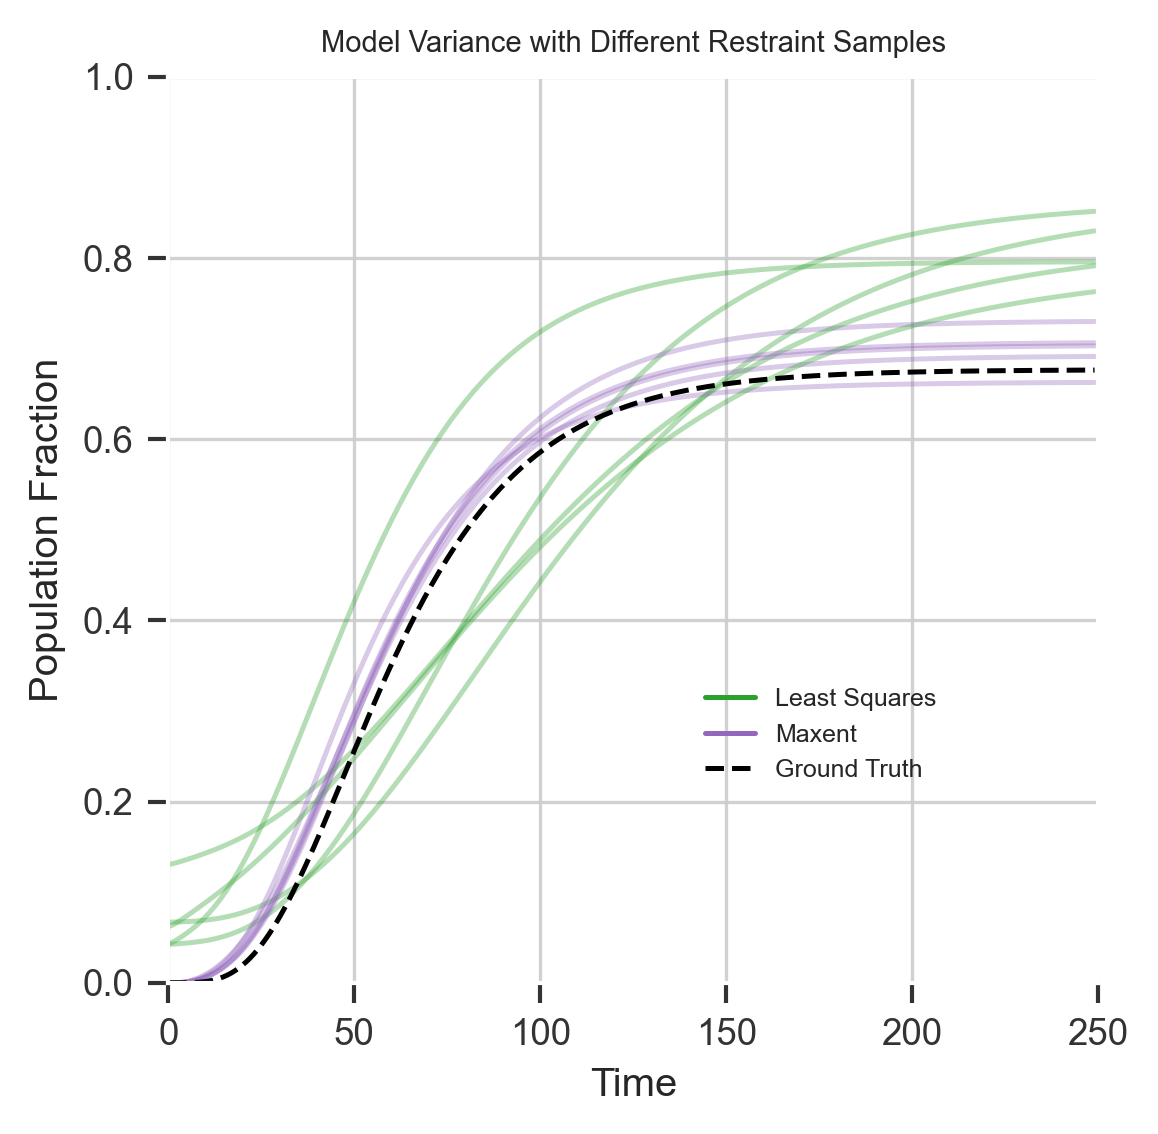

In [36]:
HperMaxEnt_sample_trajs = np.load('HyperMaxEnt_sample_trajs.npy')
LS_sample_trajs = np.load('LS_sample_trajs.npy')
fig, ax = plt.subplots(figsize=(4,4), dpi=300) 
plt.rc('axes', titlesize=7)
plt.setp(plt.gca(), ylabel='Population Fraction' ,xlabel='Time', title = "Model Variance with Different Restraint Samples", xlim =[0, 250], ylim =[0, 1.0], facecolor ='white' )
for i,y in enumerate(LS_sample_trajs):
    plt.plot(x, y[:,2,4], color= 'C2', alpha=0.35)
    plt.plot(x, HyperMaxEnt_sample_trajs[i,:,2,4], color= 'C4', alpha=0.35)
plt.plot(ref_traj[:,2,4],linestyle='--', color= 'k', label='Ground Truth')
plt.legend(bbox_to_anchor=(0.65,0.45), fontsize=6)
hand, labl = ax.get_legend_handles_labels()
predicted_label_LS = 'Least Squares'
predicted_line_LS = plt.Line2D((0,1),(0,0), color='C2')
predicted_label_HM = 'Maxent'
predicted_line_HM = plt.Line2D((0,1),(0,0), color='C4')
plt.legend([predicted_line_LS, predicted_line_HM]+[handle for i,handle in enumerate(hand)],
              [predicted_label_LS, predicted_label_HM]+[label for i,label in enumerate(labl)]
                , bbox_to_anchor=(0.85,0.35), fontsize=6)
plt.savefig('neurips_LS.png', transparent=False, dpi = 300)

print(np.mean(np.var(HyperMaxEnt_sample_trajs[:,:,2,4], axis=0)))
print(np.mean(np.var(LS_sample_trajs[:,:,2,4], axis=0)))


In [198]:
abc_sample_trajs = np.load('abc_traj_folds.npy')
sbi_sample_trajs = np.load('sbi_traj_folds.npy')
HperMaxEnt_sample_trajs = np.load('HyperMaxEnt_sample_trajs.npy')
LS_sample_trajs = np.load('LS_sample_trajs.npy')
def find_std(sample_trajs):
    std_0 = np.std(sample_trajs[:,0,2,4])
    std_mid = np.std(sample_trajs[:,125,2,4])
    std_end = np.std(sample_trajs[:,-1,2,4])
    return [std_0, std_mid, std_end]
    
std_abc = find_std(abc_sample_trajs)
std_sbi = find_std(sbi_sample_trajs)
std_HperMaxEnt = find_std(HperMaxEnt_sample_trajs)
std_LS = find_std(LS_sample_trajs)
print('MaxEnt std : ', std_HperMaxEnt)
print('Least-squares std : ', std_LS)
print('ABC std : ', std_abc)
print('SNLE std : ', std_sbi)

stds = np.array(np.round([std_HperMaxEnt, std_LS, std_abc, std_sbi],3))
print (stds)

MaxEnt std :  [0.0, 0.015313753385831025, 0.02195049051761623]
Least-squares std :  [0.03237824684813623, 0.0746572138387371, 0.031077760610797114]
ABC std :  [0.0, 0.008774095712732678, 0.015503705331361136]
SNLE std :  [0.0, 0.23478273589286525, 0.26162770979084016]
[[0.    0.015 0.022]
 [0.032 0.075 0.031]
 [0.    0.009 0.016]
 [0.    0.235 0.262]]


(250, 3, 5)


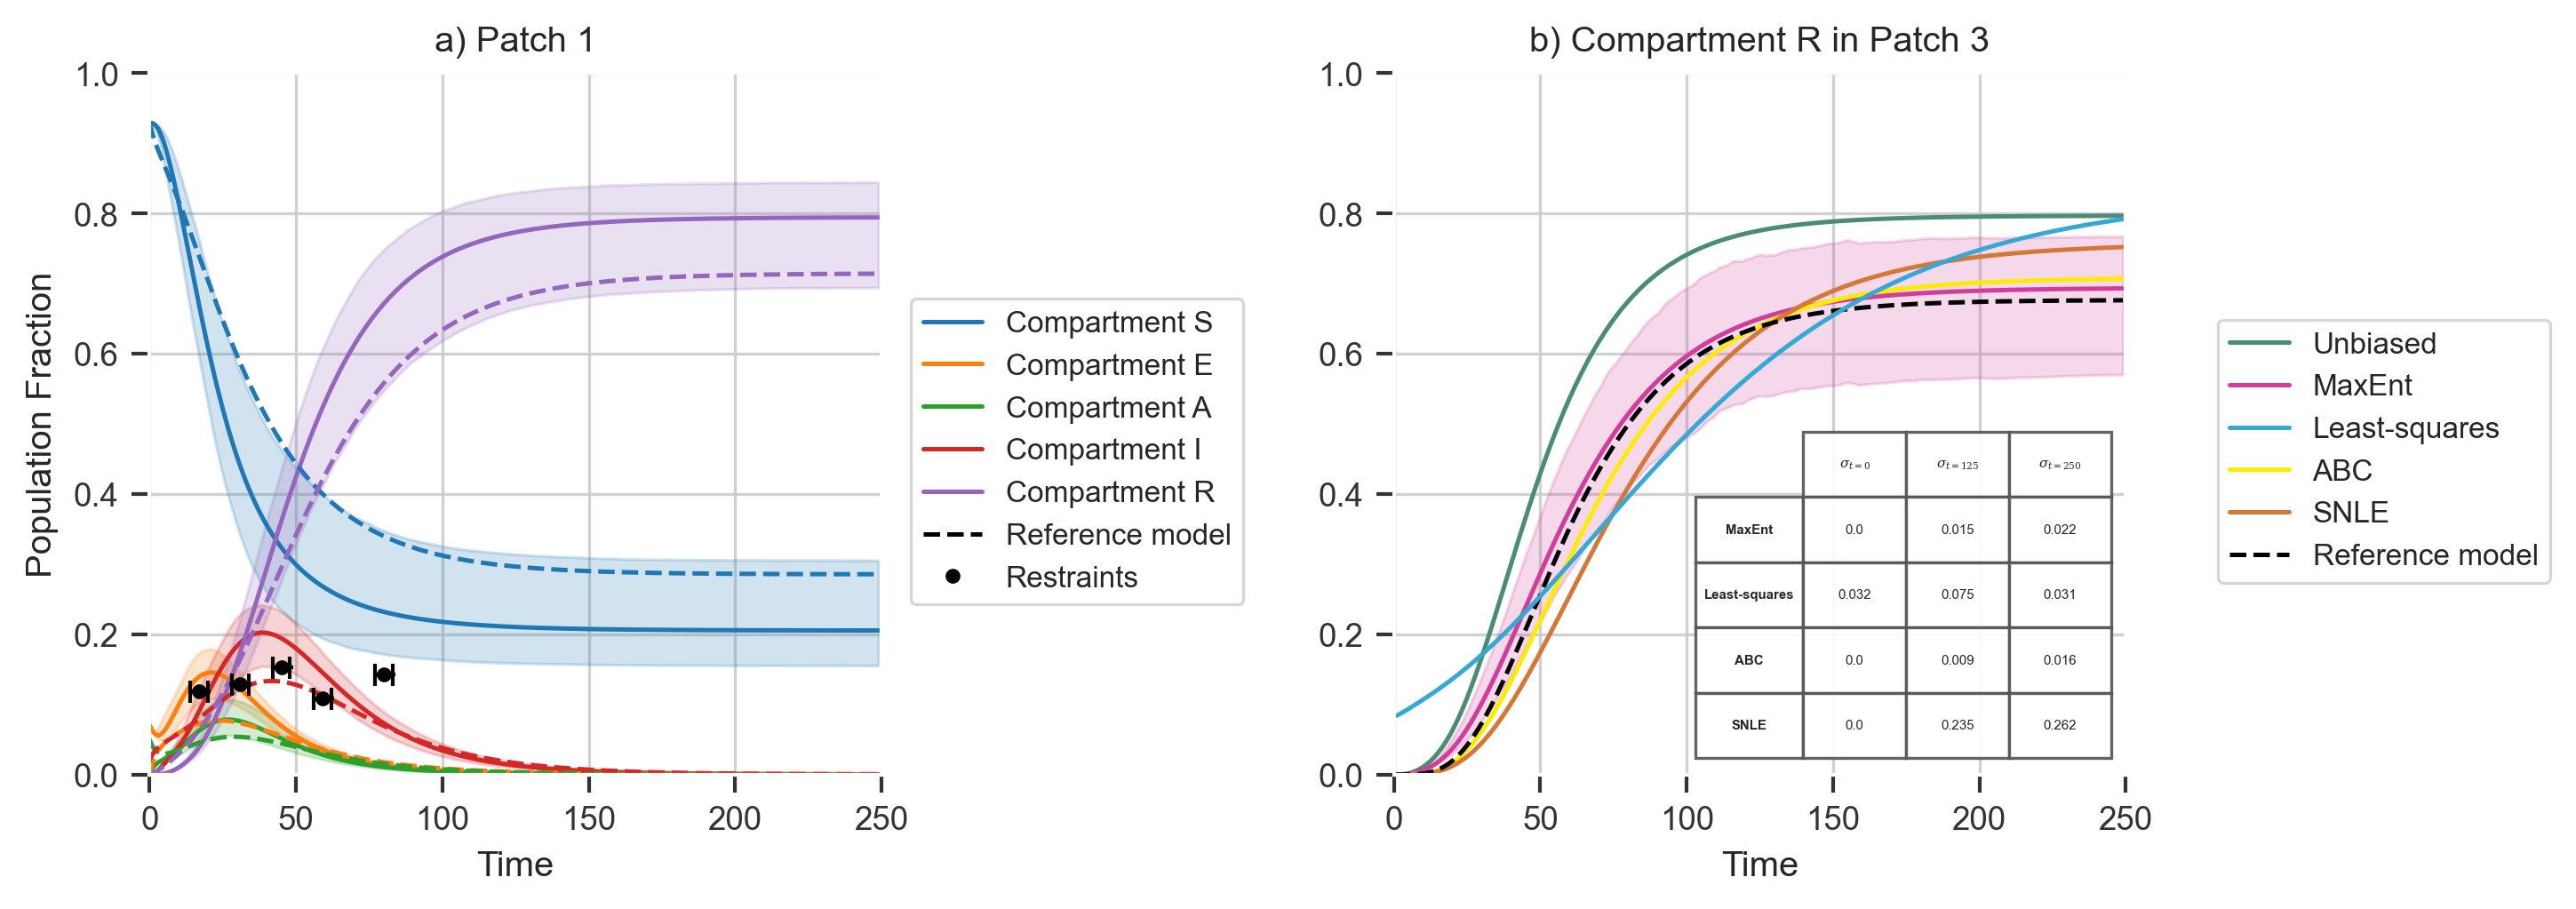

In [291]:
def set_align_for_column(table, col, align="left"):
    cells = [key for key in table._cells if key[1] == col]
    for cell in cells:
        table._cells[cell]._loc = align
        
plt.rc('axes', titlesize=8)
abc_trajs = np.load('mean_abc_traj.npy')
sbi_trajs = np.load('mean_sbi_traj.npy')
from matplotlib.font_manager import FontProperties
import seaborn as sns
sns.set_context('paper')
sns.set_style('darkgrid',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#333333', 'ytick.color': '#333333'})
plt.rcParams["mathtext.fontset"] = "dejavuserif"
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e']


import matplotlib.markers as mmark
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.9
plt.rcParams['grid.color'] = "#cccccc"
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(11,3.5), dpi =300, gridspec_kw={'width_ratios': [3,3,1]})

# fig.suptitle('Comparing Methods Performance', y = 1.0, fontsize = 18)
maxentep.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True, ax =axs[0], add_legend= True, alpha = 0.2)
axs[0].plot(ref_traj[:,0],linestyle='--')
axs[0].set_ylabel('Population Fraction')
plt.setp(axs[0], xlabel='Time', title = 'a) Patch 1', xlim =[0, 250], ylim =[0, 1.0], facecolor ='white' )
for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(0)]):
                pf(axs[0],0, color='black')
Reference_line = plt.Line2D((0,1),(0,0), color='k', linestyle='--')
rs_marker = plt.Line2D((0,1),(0,0), color='k', marker='o',linestyle='', ms=3)
hand, labl = axs[0].get_legend_handles_labels()
Reference_label = 'Reference model'
Restraints_label = 'Restraints'
axs[0].legend([handle for i,handle in enumerate(hand)]+[Reference_line,rs_marker],
              [label for i,label in enumerate(labl)]+[Reference_label,Restraints_label]
                , bbox_to_anchor=(1.02,0.7), fontsize=8, frameon=True, fancybox=True, facecolor='white')


plt.setp(axs[1], xlabel='Time', title = 'b) Compartment R in Patch 3', xlim =[0, 250], ylim =[0, 1.0], facecolor ='white' )
mtrajs_biased = np.sum(me_model.trajs * me_model.traj_weights[:, np.newaxis, np.newaxis, np.newaxis], axis=0)
w = np.ones(trajs.shape[0])
w /=np.sum(w)
mtrajs_unbiased = np.sum(trajs * w[:, np.newaxis, np.newaxis, np.newaxis], axis=0)
mtrajs_hyperbiased = np.sum(hme_model.trajs * hme_model.traj_weights[:, np.newaxis, np.newaxis, np.newaxis], axis=0)
mtrajs_regressedbiased = np.sum(regressed_traj, axis=0)
x = range(trajs.shape[1])
# axs[1].plot(x, mtrajs_biased[:,2,4], color= 'C0', label='MaxEnt biased model')
qtrajs_hyperbiased = np.apply_along_axis(lambda x: maxentep.weighted_quantile(
    x, [1/3, 1/2, 2/3], sample_weight=hme_model.traj_weights), 0, hme_model.trajs)
qtrajs_hyperbiased[0, :, :] = np.clip(
            qtrajs_hyperbiased[0, :, :] - qtrajs_hyperbiased[1, :, :] + mtrajs_hyperbiased, 0, 1)
qtrajs_hyperbiased[2, :, :] = np.clip(
            qtrajs_hyperbiased[2, :, :] - qtrajs_hyperbiased[1, :, :] + mtrajs_hyperbiased, 0, 1)
qtrajs_hyperbiased[1, :, :] = mtrajs_hyperbiased
print(mtrajs_unbiased.shape)
# for i,y in enumerate(LS_sample_trajs):
#     axs[1].plot(y[:,2,4], color= '#35a9d4', linewidth=0.3)
axs[1].plot(x, mtrajs_unbiased[:,2,4], color= '#4a8c76',  label='Unbiased')
axs[1].plot(x, mtrajs_hyperbiased[:,2,4], color= '#D03D9A',  label='MaxEnt')
axs[1].plot(x, abc_trajs[:,2,4], color= '#fcec03')
axs[1].plot(x, sbi_trajs[:,2,4], color= '#d47837')
axs[1].plot(ref_traj[:,2,4],linestyle='--', color= 'k')
axs[1].fill_between(x, qtrajs_hyperbiased[0, :, 2, 4],qtrajs_hyperbiased[-1, :, 2, 4],
                        color='#D03D9A', alpha=0.2)
axs[1].plot(x, mtrajs_regressedbiased[:,2,4], color= '#35a9d4')
axs[1].legend(bbox_to_anchor=(0.45,0.38), fontsize=6)
hand, labl = axs[1].get_legend_handles_labels()
predicted_label_LS = 'Least-squares'
predicted_line_LS = plt.Line2D((0,1),(0,0), color='#35a9d4')
predicted_label_abc = 'ABC'
predicted_line_abc = plt.Line2D((0,1),(0,0), color='#fcec03')
predicted_label_sbi = 'SNLE'
predicted_line_sbi = plt.Line2D((0,1),(0,0), color='#d47837')
ref_label = 'Reference model'
ref_line = plt.Line2D((0,1),(0,0), color='k', linestyle='--')
axs[1].legend([handle for i,handle in enumerate(hand)] + [predicted_line_LS, predicted_line_abc, predicted_line_sbi, ref_line] ,
              [label for i,label in enumerate(labl)] + [predicted_label_LS, predicted_label_abc, predicted_label_sbi, ref_label ]
                , bbox_to_anchor=(1.6,0.67), fontsize=8, frameon=True, fancybox=True, facecolor='white')

collabel=("$\sigma_{t=0}$","$\sigma_{t=125}$", "$\sigma_{t=250}$")
axs[2].axis('tight')
axs[2].axis('off')
tb = axs[2].table(cellText=np.round(stds,3),colLabels=collabel, rowLabels=['MaxEnt', 'Least-squares', 'ABC', 'SNLE'],
                         loc='center', cellLoc='center', rowLoc='center' ,colWidths=[0.2 for x in collabel],fontsize=8,
                  edges='BRTL' , bbox=[-0.22,0.19,0.7,0.5], alpha=0.35)

for (row, col), cell in tb.get_celld().items():
  if (row == 0) or (col == -1):
    cell.set_text_props(fontproperties=FontProperties(weight='bold'))

for key, cell in tb.get_celld().items():
    cell.set_linewidth(0.8)
    cell.set_edgecolor("#545350")
    cell.set_facecolor("white")
    cell.set_alpha(0.9)
    
set_align_for_column(tb, col=0, align="center")
set_align_for_column(tb, col=1, align="center")
plt.tight_layout()
plt.subplots_adjust(wspace=0.9)
axs[2].set_position([0.652,0.041,0.15,0.7])
# axs[1].text(0.60,0.28, "5-fold std. '$\sigma $'", size=7, ha="center", 
#          transform=axs[1].transAxes, fontweight='bold', bbox={'facecolor': '#fffa69', 'alpha': 0.5, 'pad': 0})

plt.savefig('Figure_3.png', transparent=False, dpi = 300)


[ 572.7735908  746.2637107 1152.6794816 1468.5702534 1516.9541984]
[ 9.73750459 12.26920262 12.34665179 11.09788804 12.23159109]


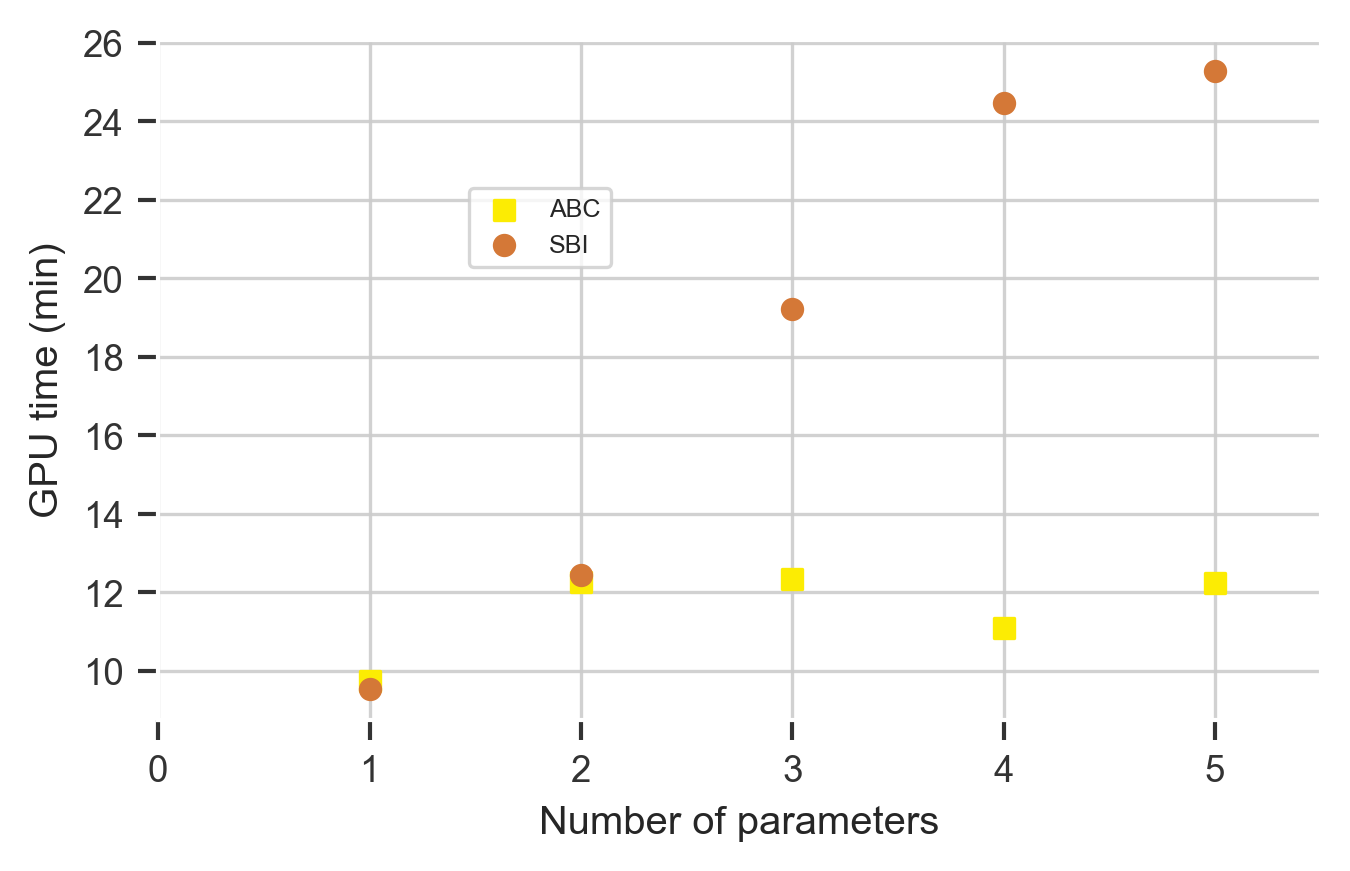

In [263]:
sbi_times = np.load('sbi_times.npy')
abc_times = np.load('abc_times.npy')
ax,fig = plt.subplots(figsize=(5,3), dpi= 300)

print (sbi_times)

sbi_times = sbi_times/60
abc_times = abc_times/60
number_parameter = range(1,6)
plt.scatter(number_parameter,abc_times, label='ABC', marker ="s",color= '#fcec03')
plt.scatter(number_parameter,sbi_times, label='SBI', color= '#d47837')
plt.setp(plt.gca(), xlim=[0,number_parameter[-1]+0.5],facecolor ='white', xlabel='Number of parameters', ylabel = 'GPU time (min)')
plt.legend(bbox_to_anchor=(0.4,0.8), fontsize=6, frameon=True, fancybox=True, facecolor='white')
print(abc_times)

In [249]:
mtrajs_hyperbiased.shape

(250, 3, 5)